In [1]:
#load rpy2 magic
%load_ext rpy2.ipython

# to switch off warning messages
import warnings
warnings.filterwarnings("ignore")

# make default cell width 85% of available screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

# show multiple tables in python shells
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# load R libraries & functions
%R options(warn=-1)
%R library(RColorBrewer)
%R library(ggplot2)
%R library(gplots)
%R library(gridExtra)
%R library(ggrepel)
    
# load python modules
import glob
import re
import sys
import os
import rpy2.robjects as robjects
import cgatcore.database as DB
import sqlite3
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

db = "./csvdb"

# **MEME-ChIP Report**
***
## **MEME**
- Searches for **novel** ungapped motifs in input sequences
- TOMTOM compares discovered motifs against database(s) of known motifs

In [2]:
%%R

# R functions
theme_notebook <- function(base_size=18, base_family="helvetica") {
                  (theme_set(theme_minimal(base_size=18))
                  + theme(plot.title = element_text(face="bold", size=20, hjust=0.5),
                             text = element_text(),
                             axis.title = element_text(face="bold",size = rel(1)),
                             axis.title.y = element_text(angle=90,vjust=2, size=20),
                             axis.title.x = element_text(vjust=-0.2, size=20),
                             axis.text = element_text(size=20),
                             axis.line = element_line(colour="black"),
                             axis.ticks = element_line(),
                             legend.key = element_rect(colour = NA),
                             legend.key.size= unit(0.5, "cm"),
                             legend.margin = unit(0.5, "cm"),
                             legend.text = element_text(size=14),
                             legend.title = element_text(size=16),
                             strip.text = element_text(size=18)
                             ))
}

# Set ggplot theme
theme_set(theme_notebook(base_size=18))
Palette <- c("#E69F00", "#0072B2", "#D55E00", "#009E73", "#56B4E9",  "#999999", "#F0E442")

In [3]:
def motif_lookup(db):
    
    with open("./pipeline.yml", "r") as o:
        for line in o:
            a = re.findall("^motif_db=.*", line)
            if len(a) > 0:
                dbs = a[0].split(",")

    df1 = {}
    df2 = {}
    df3 = {}
    
    transfac = [x for x in dbs if "transfac" in x]
    jaspar = [x for x in dbs if "JASPAR" in x]
    uniprobe = [x for x in dbs if "uniprobe" in x]
    hocomoco = [x for x in dbs if "HOCOMOCO" in x]
    chen = [x for x in dbs if "chen" in x]

    n = 0
    for i in [transfac, jaspar, uniprobe]:
        n = n + 1
        if n == 1:
            db_name = "transfac"
        if n == 2:
            db_name = "jaspar"
        if n == 3:
            db_name = "uniprobe"
        meme = ''.join(i).lstrip("motif_db=")
        with open(meme, "r") as o:
            for line in o:
                motif = re.findall("^MOTIF.*", line)
                if len(motif) > 0: 
                    motif = motif[0].split(" ")
                    motif_id = motif[1]
                    motif_name = motif[2]
                    df1[motif_name] = motif_id

        if n == 1:
            dfs = pd.DataFrame.from_dict(df1, orient="index")
            dfs.columns = ["motif_id"]
            dfs["motif_name"] = dfs.index.values
            dfs.reset_index(inplace=True, drop=True)
            dfs["database"] = db_name
        else:
            dfs1 = pd.DataFrame.from_dict(df1, orient="index")
            dfs1.columns = ["motif_id"]
            dfs1["motif_name"] = dfs1.index.values
            dfs1.reset_index(inplace=True, drop=True)
            dfs1["database"] = db_name
            
            dfs = dfs.append(dfs1)

    if len(hocomoco) > 0:
        meme = ''.join(hocomoco).lstrip("motif_db=")
        with open(meme, "r") as o:
            for line in o:
                motif = re.findall("^MOTIF.*", line)
                if len(motif) > 0: 
                    motif = motif[0].split(".")
                    motif[0].split(".")
                    motif_name = str(motif[0]).replace("MOTIF ", "")
                    motif_suffix = '.'.join(motif[1:3])
                    motif_id = '.'.join([motif_name, motif_suffix])
                    df2[motif_name] = motif_id

        df2 = pd.DataFrame.from_dict(df2, orient="index")
        df2.columns = ["motif_id"]
        df2["motif_name"] = df2.index.values
        df2.reset_index(inplace=True, drop=True)
        df2["database"] = "hocomoco"
    
    if len(chen) > 0:
        meme = ''.join(chen).lstrip("motif_db=")
        with open(meme, "r") as o:
            for line in o:
                motif = re.findall("^MOTIF.*", line)
                if len(motif) > 0: 
                    motif = motif[0].split(" ")
                    motif_id = motif[1]
                    motif_name = motif[1]
                    df3[motif_name] = motif_id
                
        df3 = pd.DataFrame.from_dict(df3, orient="index")
        df3.columns = ["motif_id"]
        df3["motif_name"] = df3.index.values
        df3.reset_index(inplace=True, drop=True)
        df3["database"] = "chen"
    
    # merge all dfs
    df = dfs.append([df2, df3])
    
    # add table to db
    connect = sqlite3.connect(db)
    df.to_sql("motif_table", connect, if_exists="replace", index=False)

    return df

df = motif_lookup(db)

In [4]:
def meme_summary(db, conditions="", widths="", no_peaks="", samples=""):
    beds = glob.glob("data.dir/*_meme.bed")

    if len(samples)==0:
        names = []
        for bed in beds:
            name = os.path.basename(bed).split("_")[0]
            names.append(name)
    else:
        names = samples

    # get meme-chip run params from pipeline.yml
    with open("./pipeline.yml", "r") as o:
        for line in o:
            if len(widths)==0:
                w = re.findall("^widths=.*", line)
                if len(w) > 0:
                    widths = w[0].lstrip("widths=").split(",")


            if len(no_peaks)==0:
                n = re.findall("^npeaks=.*", line)
                if len(n) > 0:
                    no_peaks = n[0].lstrip("npeaks=").split(",")

            m = re.findall("^nmotif=.*", line)
            if len(m) > 0:
                m = m[0].lstrip("nmotif=")
                no_motifs = range(1, int(m)+1)

    dfs = []
    for name in names:
        for c in conditions:
            for peaks in no_peaks:
                for width in widths:
                    table = '_'.join([name, c, str(peaks), str(width)]) + "_Meme_tomtom"
                    
                    # get corresponding meme e_values for discovered motifs from meme.txt
                    meme_out = "meme.chip.dir/" + '_'.join([name, c]) + "." + '.'.join([str(peaks), str(width)]) + "/meme_out/meme.txt"
                    if os.path.exists(meme_out):
                        n = 0
                        with open(meme_out, "r") as open_meme:
                            for line in open_meme:
                                motif = re.findall("^MOTIF.*", line)
                                if len(motif) > 0:
                                    n = n + 1
                                    nmotif = str(motif[0].split(" ")[0:3][-1])
                                e_val = re.findall("E-value.*", str(motif))
                                if len(e_val) > 0:
                                    e_value = e_val[0].split(" ")[-1].replace("'", "").strip("]")

                                if (len(e_val)>0) & (len(motif) > 0):
                                    df = pd.DataFrame([nmotif, e_value]).transpose()
                                    df.columns = ["query_id", "meme_evalue"]
                                    df["run"] = str(table).rstrip("_Meme_tomtom")
                                    dfs.append(df)
    c = 0
    for df in dfs:
        c = c + 1
        if c ==1:
            motifs = df
        else:
            motifs = motifs.append(df)

    motifs = motifs.drop_duplicates()
    
    # add table to db
    connect = sqlite3.connect(db)
    df.to_sql("meme_motifs", connect, if_exists="replace", index=False)
                    
    return motifs

meme = meme_summary(db, conditions=["increase", "decrease"])

In [5]:
def memechip_summary(db, conditions="", widths="", no_peaks="", samples=""):
    beds = glob.glob("data.dir/*_meme.bed")

    if len(samples)==0:
        names = []
        for bed in beds:
            name = os.path.basename(bed).split("_")[0]
            names.append(name)
    else:
        names = samples

    # get meme-chip run params from pipeline.yml
    with open("./pipeline.yml", "r") as o:
        for line in o:
            if len(widths)==0:
                w = re.findall("^widths=.*", line)
                if len(w) > 0:
                    widths = w[0].lstrip("widths=").split(",")

            if len(no_peaks)==0:
                n = re.findall("^npeaks=.*", line)
                if len(n) > 0:
                    no_peaks = n[0].lstrip("npeaks=").split(",")

            m = re.findall("^nmotif=.*", line)
            if len(m) > 0:
                m = m[0].lstrip("nmotif=")
                no_motifs = range(1, int(m)+1)

    # get existing tables in db
    dbhandle = sqlite3.connect(db)
    cc = dbhandle.cursor()
    cc.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tabs = cc.fetchall()
    tables = pd.DataFrame(tabs, columns=["tables"])

    dfs = []
    for name in names:
        for c in conditions:
            for peaks in no_peaks:
                for width in widths:
                    table = '_'.join([name, c, str(peaks), str(width)]) + "_Meme_tomtom"

                    if tables["tables"].str.contains(table).any():

                        n = 0
                        for query in no_motifs:
                            n = n + 1
                            statement = '''select a.query_id, a.query_consensus, a.target_id, 
                                        b.motif_name, b.database, a.e_value as tomtom_evalue, a.orientation
                                        from %(table)s a, motif_table b where a.target_id = b.motif_id 
                                        and a.query_id = %(query)s 
                                        order by e_value asc''' % locals()

                            df = DB.fetch_DataFrame(statement, db)
                            df = df.drop_duplicates()
                            df["run"] = str(table).rstrip("_Meme_tomtom")
                            df["DESeq2_comparison"] = df["run"].apply(lambda x: x.split("_")[0])
                            df["condition"] = df["run"].apply(lambda x: x.split("_")[1])
                            df["no_peaks"] = df["run"].apply(lambda x: x.split("_")[2])
                            df["window"] = df["run"].apply(lambda x: x.split("_")[3])

                            if n == 1:
                                result = df
                            else:
                                result = result.append(df)

                        dfs.append(result)
                        
    c = 0
    for df in dfs:
        c = c + 1
        if c == 1:
            motifs = df
        else:
            motifs = motifs.append(df)
            
    motifs["motif_name"] = motifs["motif_name"].apply(lambda x: x.replace("_MOUSE", ""))
    
    return motifs

motifs = memechip_summary(db, conditions=["increase", "decrease"])

In [6]:
def analyse_meme(motifs, meme):

    # annotate dfs for merging
    motifs["merge"] = motifs.apply(lambda x: '_'.join([x.run, str(x.query_id)]), axis=1)
    meme["merge"] = meme.apply(lambda x: '_'.join([x.run, str(x.query_id)]), axis=1)

    meme.drop(["query_id", "run"], axis=1, inplace=True) # drop extra cols

    # merge dfs
    meme_chip = pd.merge(meme, motifs, how="inner", on="merge")
    meme_chip.drop_duplicates(inplace=True)

    meme_chip["meme_evalue"] = meme_chip["meme_evalue"].apply(lambda x: float(x)) # correct type
    meme_chip["settings"] = meme_chip["no_peaks"] + "_" + meme_chip["window"] # make column for plot annotations

    if len(meme_chip[meme_chip["meme_evalue"] < 0.05])==0:
        print "No significant motifs detected by MEME"
        meme_chip = None

    else:
        # subset on sig motifs & sig matches
        meme_chip = meme_chip[(meme_chip.tomtom_evalue < 0.05) & (meme_chip.meme_evalue < 0.05)].sort_values(["meme_evalue", "tomtom_evalue"], ascending=True)
        meme_chip = meme_chip[meme_chip["meme_evalue"] != 0]
        meme_chip = meme_chip[meme_chip["tomtom_evalue"] != 0]

    return meme_chip

meme_chip = analyse_meme(motifs, meme)

## Effect of MEME-ChIP Settings on MEME & TOMTOM

In [7]:
# make new df for plots
meme_evalue = meme_chip.copy(deep=True)
meme_evalue.index.name = None
meme_evalue.reset_index(inplace=True, drop=True)
meme_evalue = meme_evalue.drop_duplicates(["target_id", "motif_name", "merge"], keep="first")

In [8]:
%%R  -w 1200 -h 400 -i meme_evalue

# meme_chip <- read.csv("meme_chip_summary.txt", sep="\t", row.names=1)

a <- ggplot(meme_evalue, aes(y=-log10(tomtom_evalue), x=-log10(meme_evalue), shape=factor(query_id), alpha=condition, colour=database)) +
        geom_jitter(size=3) + 
        scale_alpha_discrete(range=c(0.4, 1)) +
        facet_grid(settings ~ DESeq2_comparison) +
        theme(legend.position="bottom", legend.direction="horizontal")
        
b <- ggplot(meme_evalue, aes(y=-log10(meme_evalue), x=window, fill=no_peaks)) + 
        geom_boxplot(aes(alpha=meme_evalue), position="dodge")  +
        scale_fill_manual(values=Palette) + 
        labs(title="Meme motif discovery", x="Peak width")
        
c <- ggplot(meme_evalue, aes(y=-log10(tomtom_evalue), x=window, fill=no_peaks)) + 
        geom_boxplot(aes(alpha=meme_evalue), position="dodge")  +
        scale_fill_manual(values=Palette) + 
        labs(title="Tomtom motif comparison", x="Peak width")

In [9]:
meme_motif_no = meme_evalue.groupby(["run", "window", "no_peaks"]).agg({"motif_name":"count"})
meme_motif_no.reset_index(inplace=True)

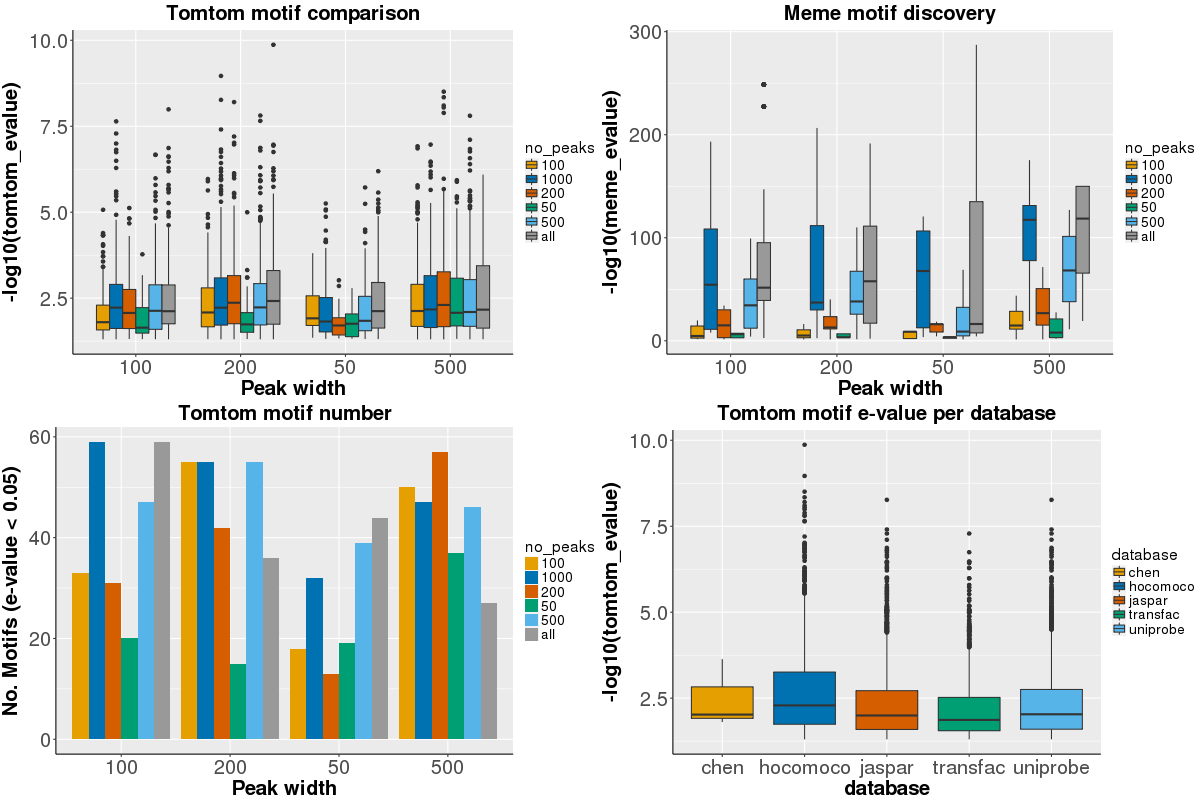

In [10]:
%%R -i meme_motif_no,meme_chip -w 1200 -h 800

# meme_motif_no <- meme_motif_no[order(meme_motif_no$motif_name, descending=TRUE), ]
d <- ggplot(meme_motif_no, aes(y=motif_name, x=window, fill=no_peaks)) + 
        geom_bar(stat="identity", position="dodge")  +
        scale_fill_manual(values=Palette) + 
        labs(title="Tomtom motif number", x="Peak width", y="No. Motifs (e-value < 0.05)")# +
#         scale_x_discrete(limits=unique(meme_motif_no$window))
        
e <- ggplot(meme_chip, aes(y=-log10(tomtom_evalue), x=database, fill=database)) + 
        geom_boxplot() +
        scale_fill_manual(values=Palette) +
        labs(title="Tomtom motif e-value per database")
        
grid.arrange(c, b, d, e, ncol=2, nrow=2)

## MEME-ChIP Summary
* For simplicity results from all MEME-ChIP runs are aggregated
    * TOMTOM & MEME e-values are averaged across runs
    * No. motif occurances between runs and databases is counted
    * All MEME motifs have an e-value < 0.05
* This is to provide an overview of the data, do not use for downstream analysis

In [11]:
# aggregate data
meme_summary = meme_chip.groupby(["target_id", "motif_name", "query_id", "DESeq2_comparison", "condition"]).agg({"tomtom_evalue":"mean", "meme_evalue":"mean", "run":"count", "database":"count"})
meme_summary.reset_index(inplace=True)

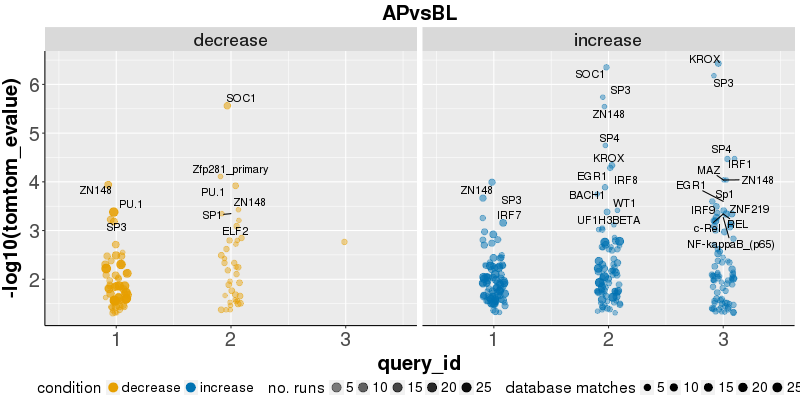

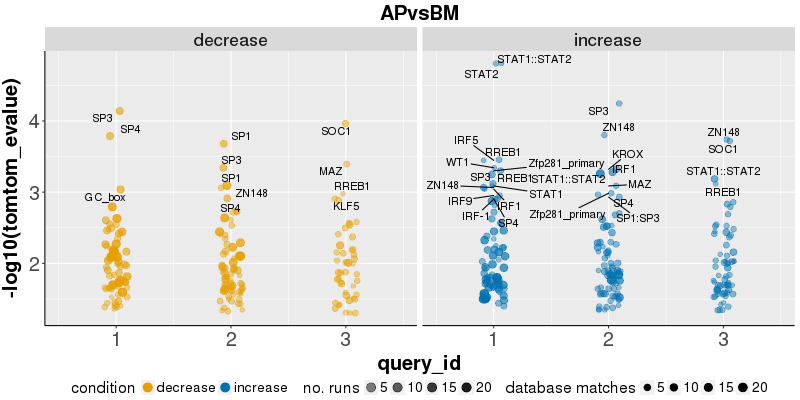

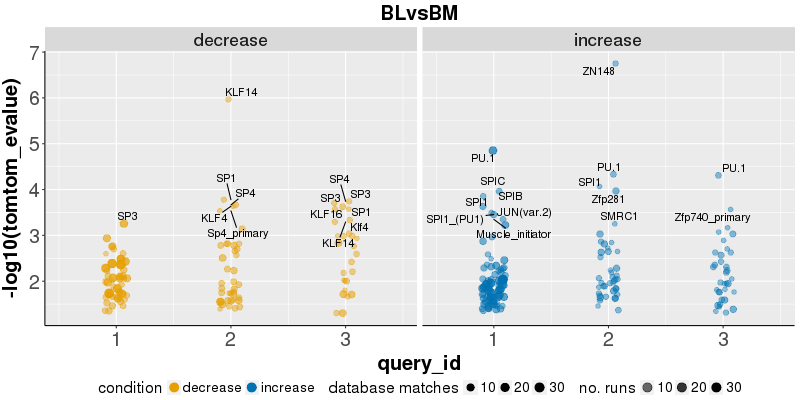

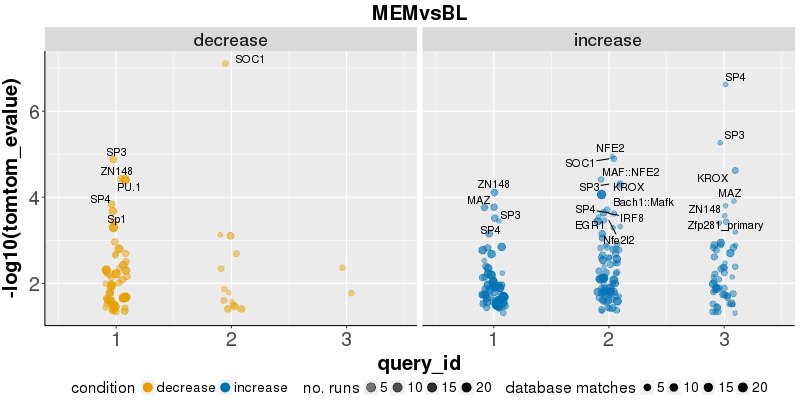

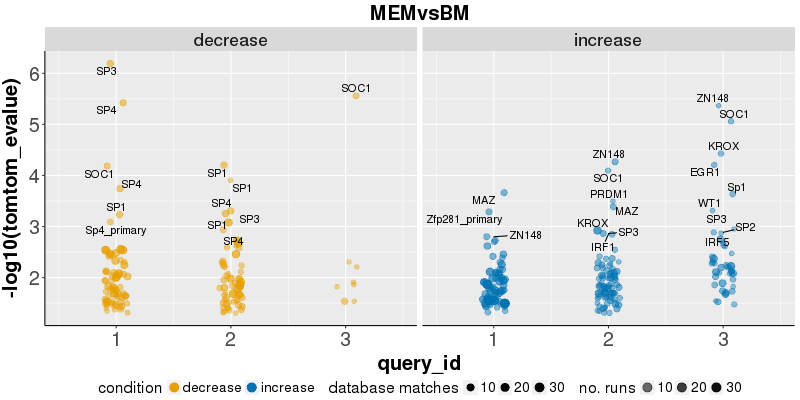

In [12]:
%%R -i meme_summary -w 800 -h 400

for (comp in unique(meme_summary$DESeq2_comparison)){

    df <- subset(meme_summary, DESeq2_comparison == comp)

    p <- ggplot(df, aes(y=-log10(tomtom_evalue), x=query_id, alpha=run, colour=condition)) +
            geom_point(aes(size=database), position=position_jitterdodge()) + 
            scale_size(range=c(2,4), name="database matches") +
            scale_alpha(range=c(0.4,1), name="no. runs") +
            scale_shape_manual(values=c(16, 17, 15), name="meme motif") +
            geom_text_repel(
                data=df[-log10(df$tomtom_evalue) > 
                          quantile(-log10(df$tomtom_evalue), 0.9, na.rm=T), ], 
                aes(label=motif_name), colour="black", alpha=1, position=position_jitterdodge()) +
            facet_wrap(~ condition) +
            theme(legend.position="bottom", legend.direction="horizontal") +
            scale_colour_manual(values=Palette) +
            guides(color=guide_legend(override.aes=list(size=4)), alpha=guide_legend(override.aes=list(size=4))) +
            labs(title=comp)
    
    grid.arrange(p, ncol=1, nrow=1)
}

## MEME & TOMTOM Results for Each Run & Sample
* Multiple database hits for the same motif discovered by MEME are merged (TOMTOM e-values are averaged)

In [13]:
# make new df for plot
meme_graph = meme_chip.copy(deep=True)

# count occurnaces of the same motif matching a TF in many databases
# average tomtom_evalue in these instances
meme_graph = meme_graph.groupby(["merge", "target_id", "motif_name", "query_id","orientation", "run", "DESeq2_comparison", "condition", "settings"]).agg({"database":"count", "meme_evalue":"min", "tomtom_evalue":"mean"})
meme_graph.reset_index(inplace=True)

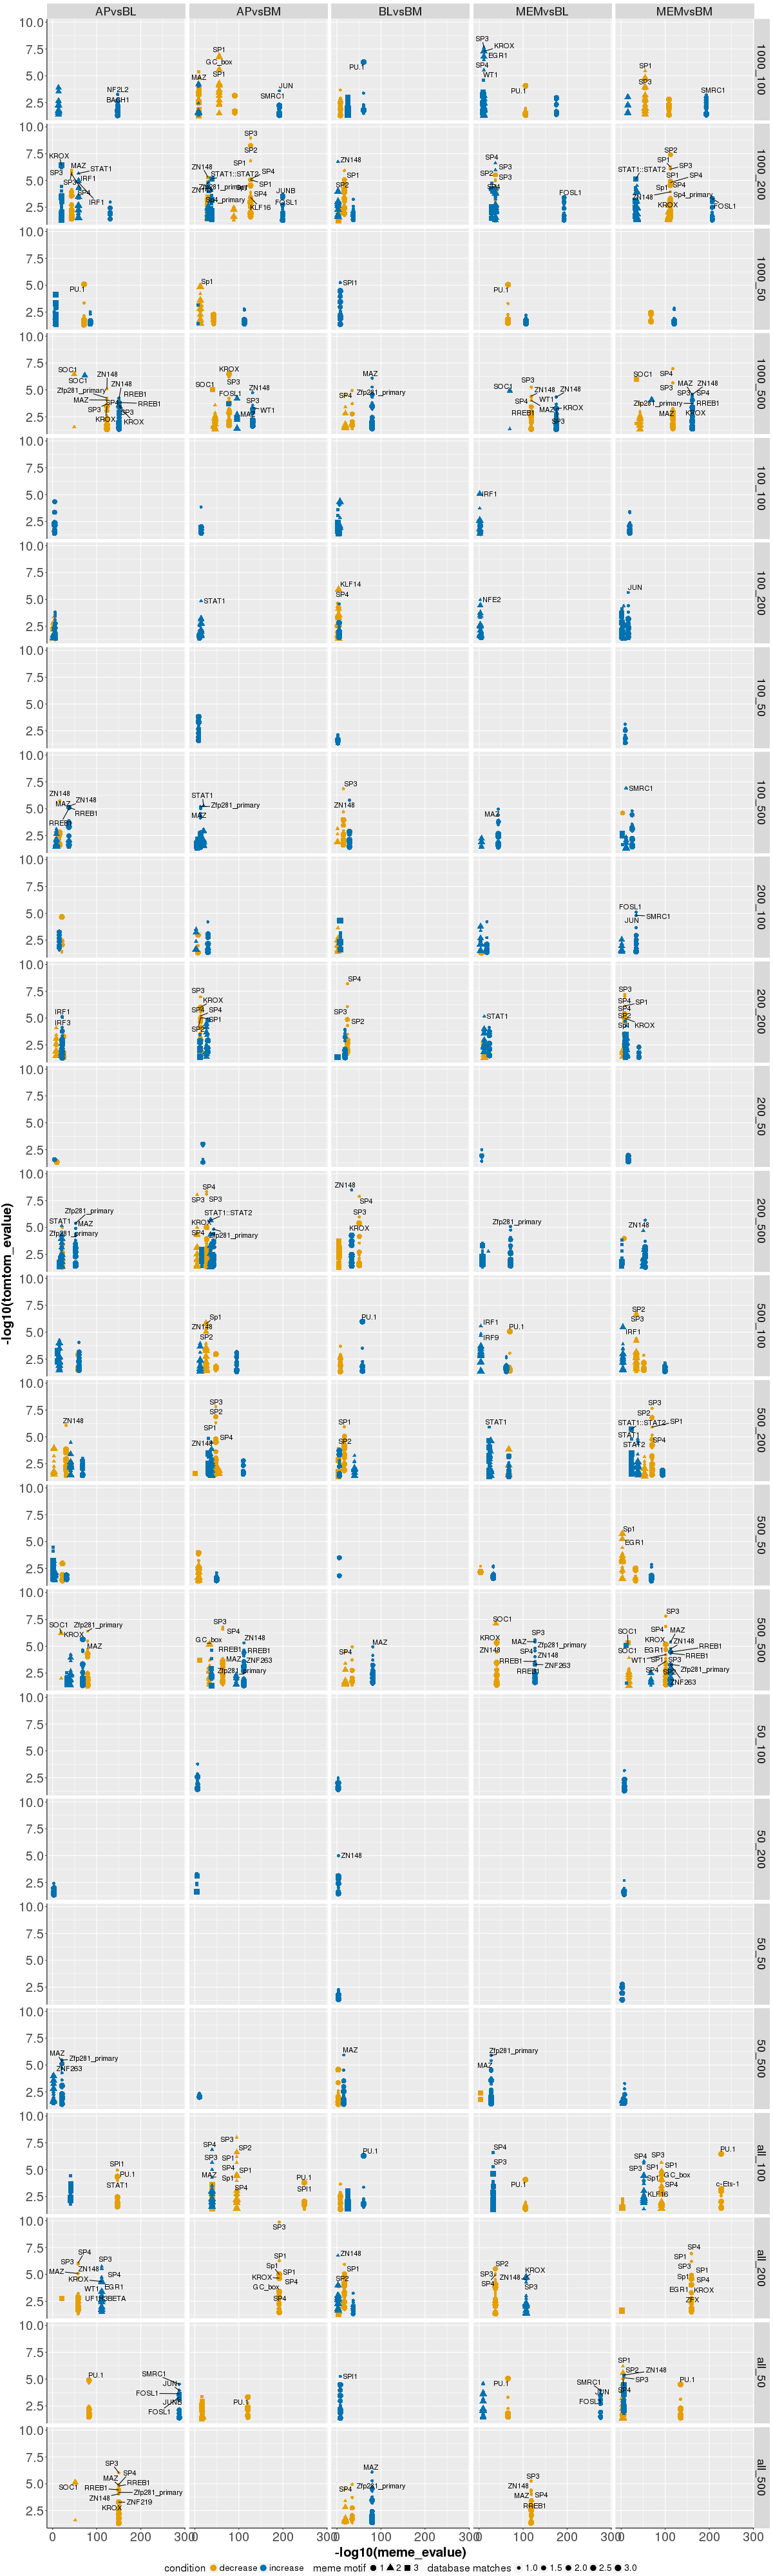

In [14]:
%%R -i meme_graph -w 1200 -h 4000

ggplot(meme_graph, aes(y=-log10(tomtom_evalue), x=-log10(meme_evalue), shape=factor(query_id), colour=condition)) +
    geom_jitter(aes(size=database)) + 
    scale_size(range=c(2,4), name="database matches") +
    scale_shape_manual(values=c(16, 17, 15), name="meme motif") +
    geom_text_repel(data=meme_graph[-log10(meme_graph$"meme_evalue") > 
                                   quantile(-log10(meme_graph$"meme_evalue"), 0.8, na.rm=T) &
                                   -log10(meme_graph$"tomtom_evalue") > 
                                   quantile(-log10(meme_graph$"tomtom_evalue"), 0.8, na.rm=T) |#, ], 
                                   -log10(meme_graph$"meme_evalue") > quantile(-log10(meme_graph$"meme_evalue"), 0.95, na.rm=T)  &
                                   -log10(meme_graph$"tomtom_evalue") > 
                                   quantile(-log10(meme_graph$"tomtom_evalue"), 0.9, na.rm=T) |
                                   -log10(meme_graph$"tomtom_evalue") > quantile(-log10(meme_graph$"tomtom_evalue"), 0.95, na.rm=T), ], 
                    aes(y=-log10(tomtom_evalue), x=-log10(meme_evalue), label=motif_name), colour="black") +
    facet_grid(settings ~ DESeq2_comparison) +
    theme(legend.position="bottom", legend.direction="horizontal") +
    scale_colour_manual(values=Palette) +
    guides(color=guide_legend(override.aes=list(size=4))) +
    guides(shape=guide_legend(override.aes=list(size=4)))

### Top Database Matches per MEME Motif 
* All discovered motifs have e-value < 0.05
* Multiple database matches for MEME motifs are grouped by TF name & TOMTOM e-values averaged

In [15]:
# make extra cols for annotation
meme_graph["width"] = meme_graph["settings"].apply(lambda x: "width_" + x.split("_")[1])
meme_graph["peaks"] = meme_graph["settings"].apply(lambda x: "npeaks_" + x.split("_")[0])

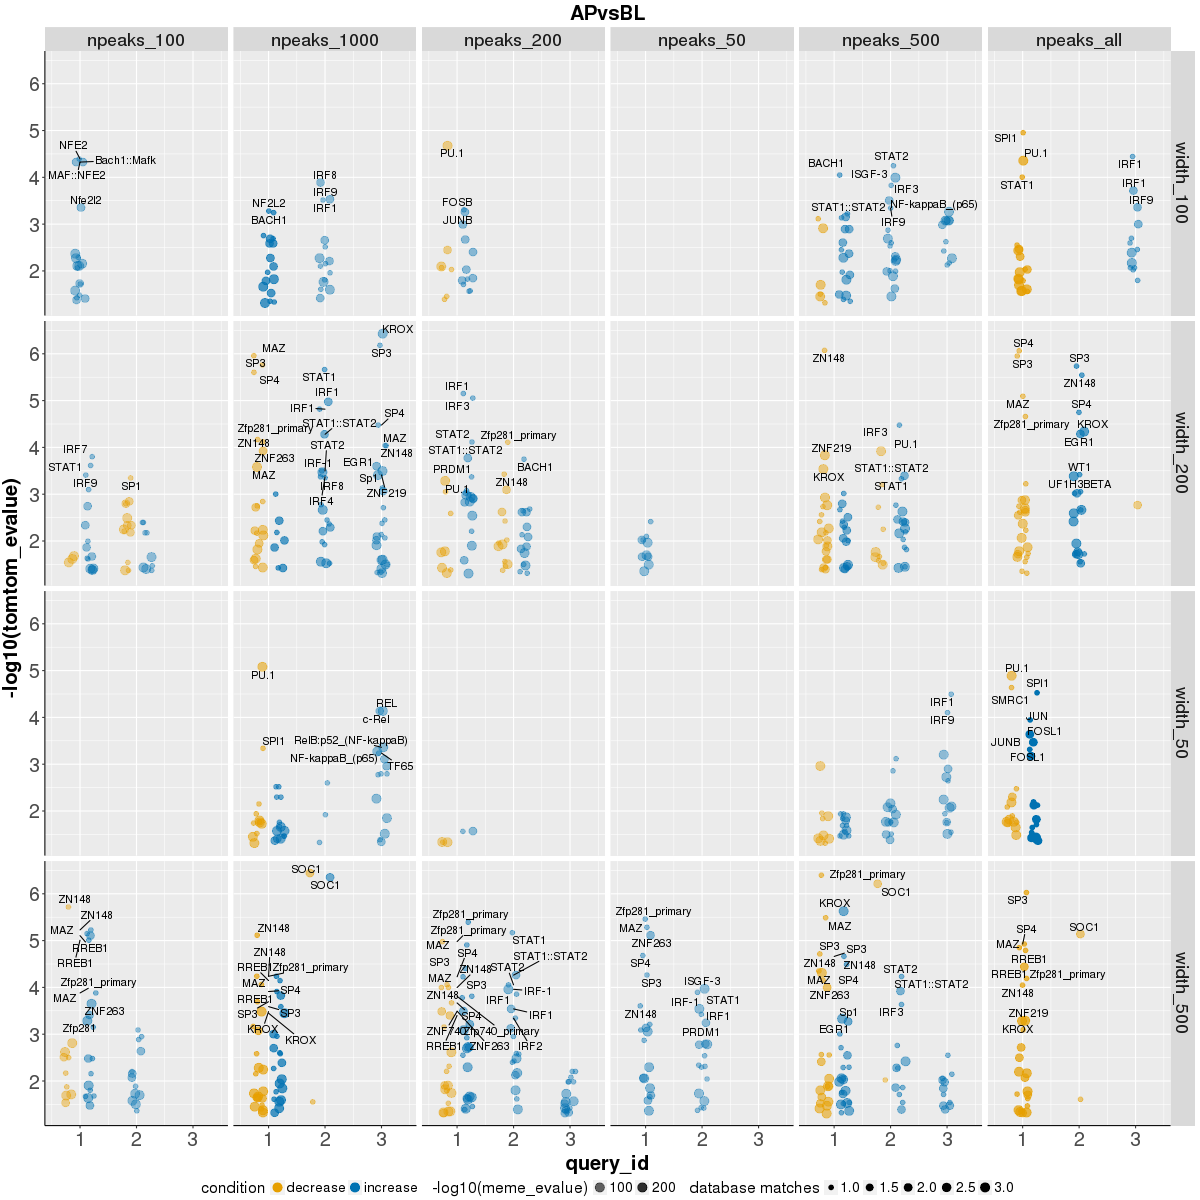

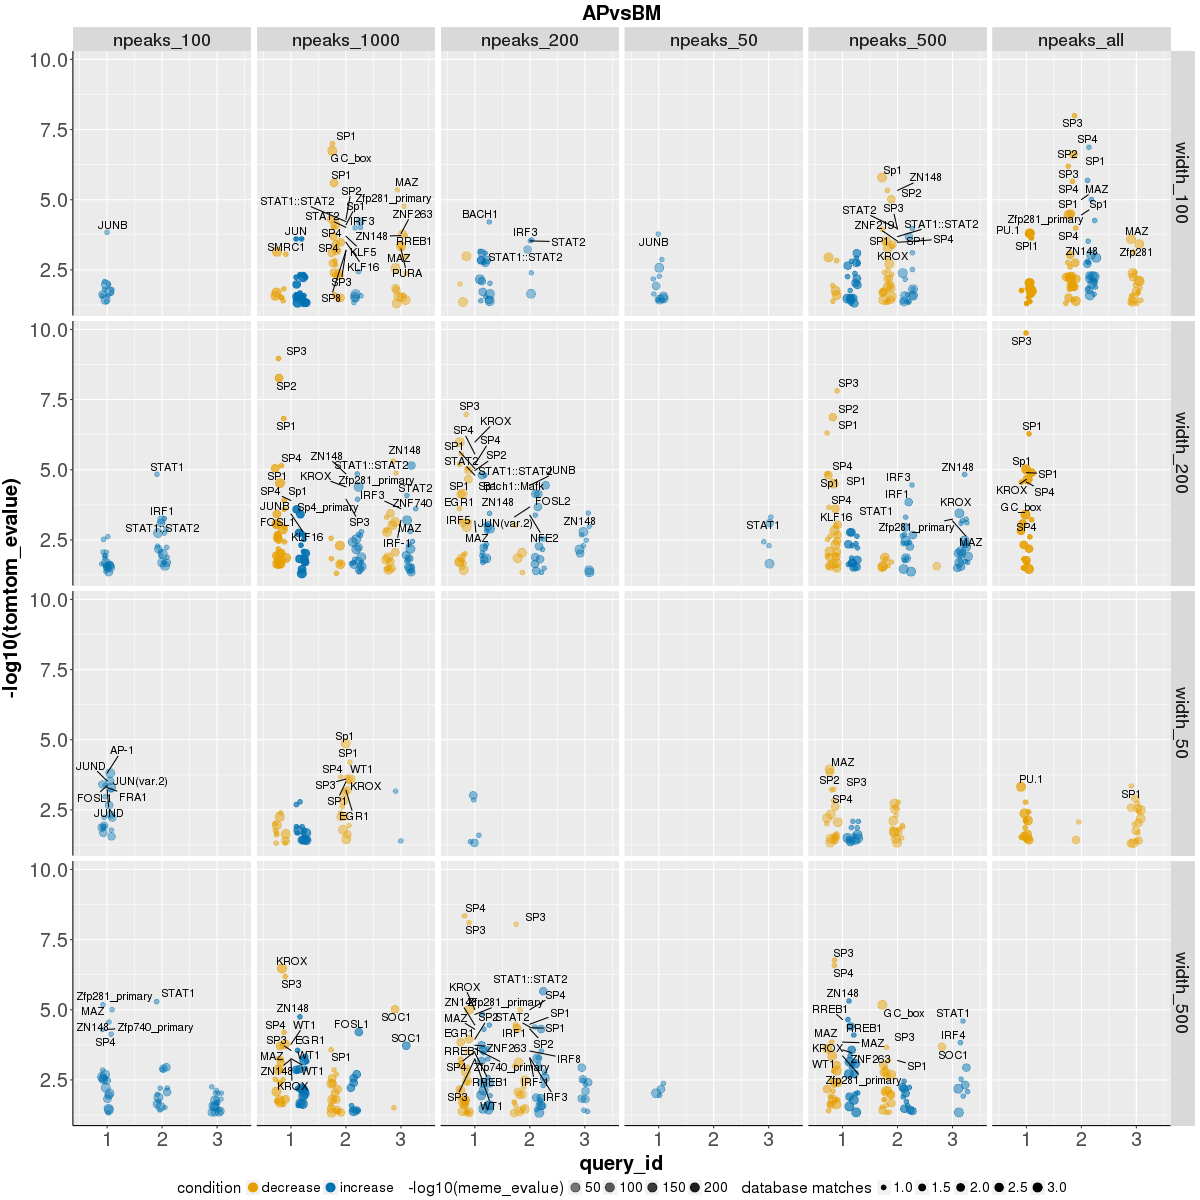

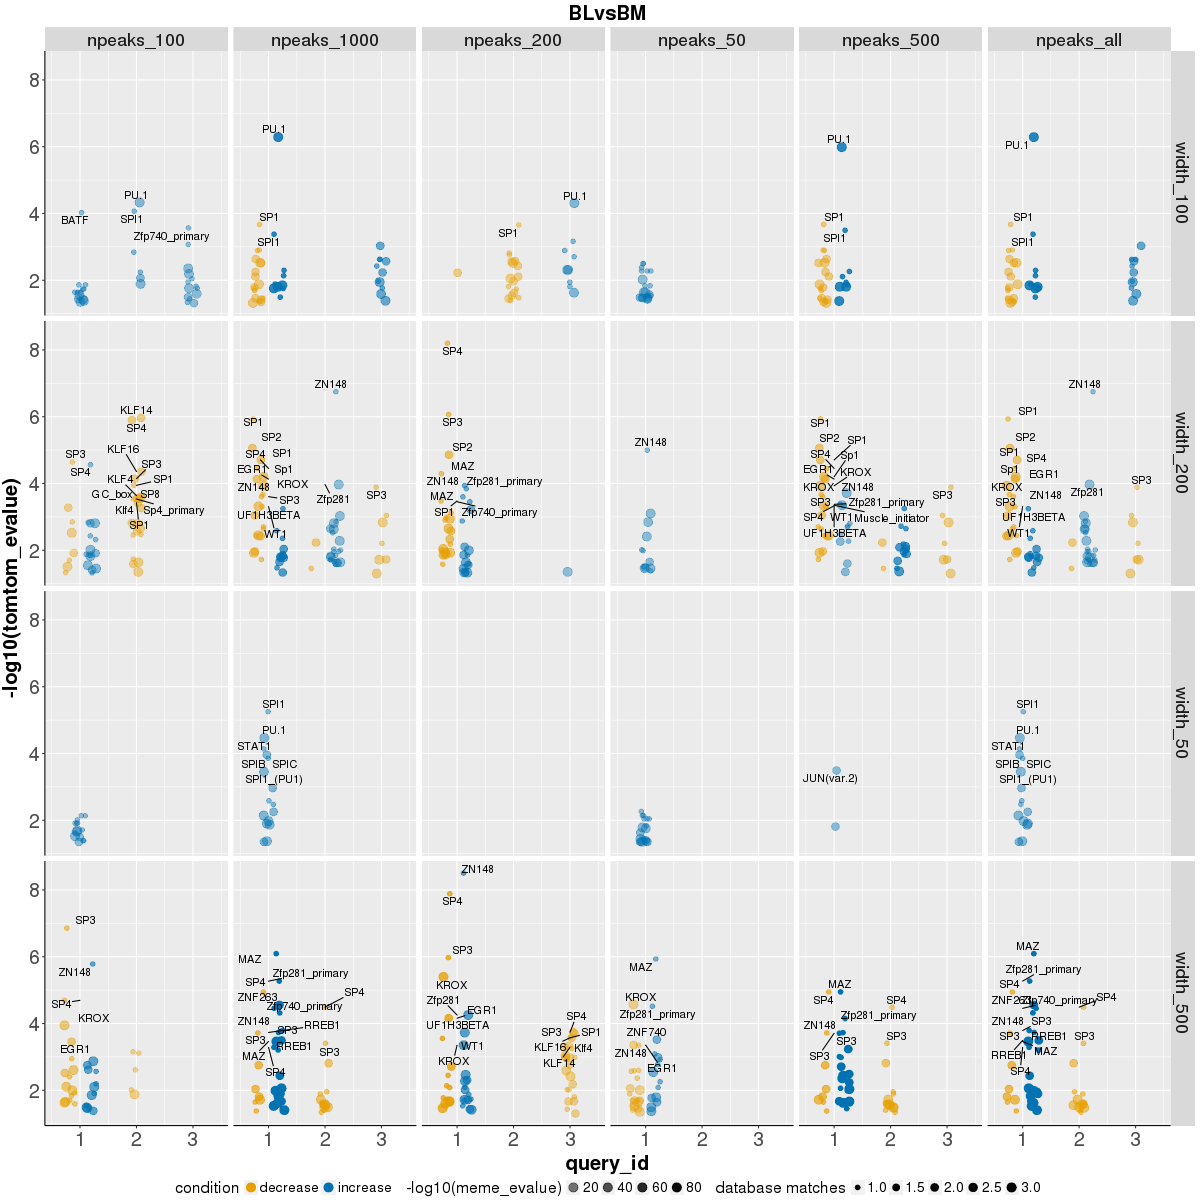

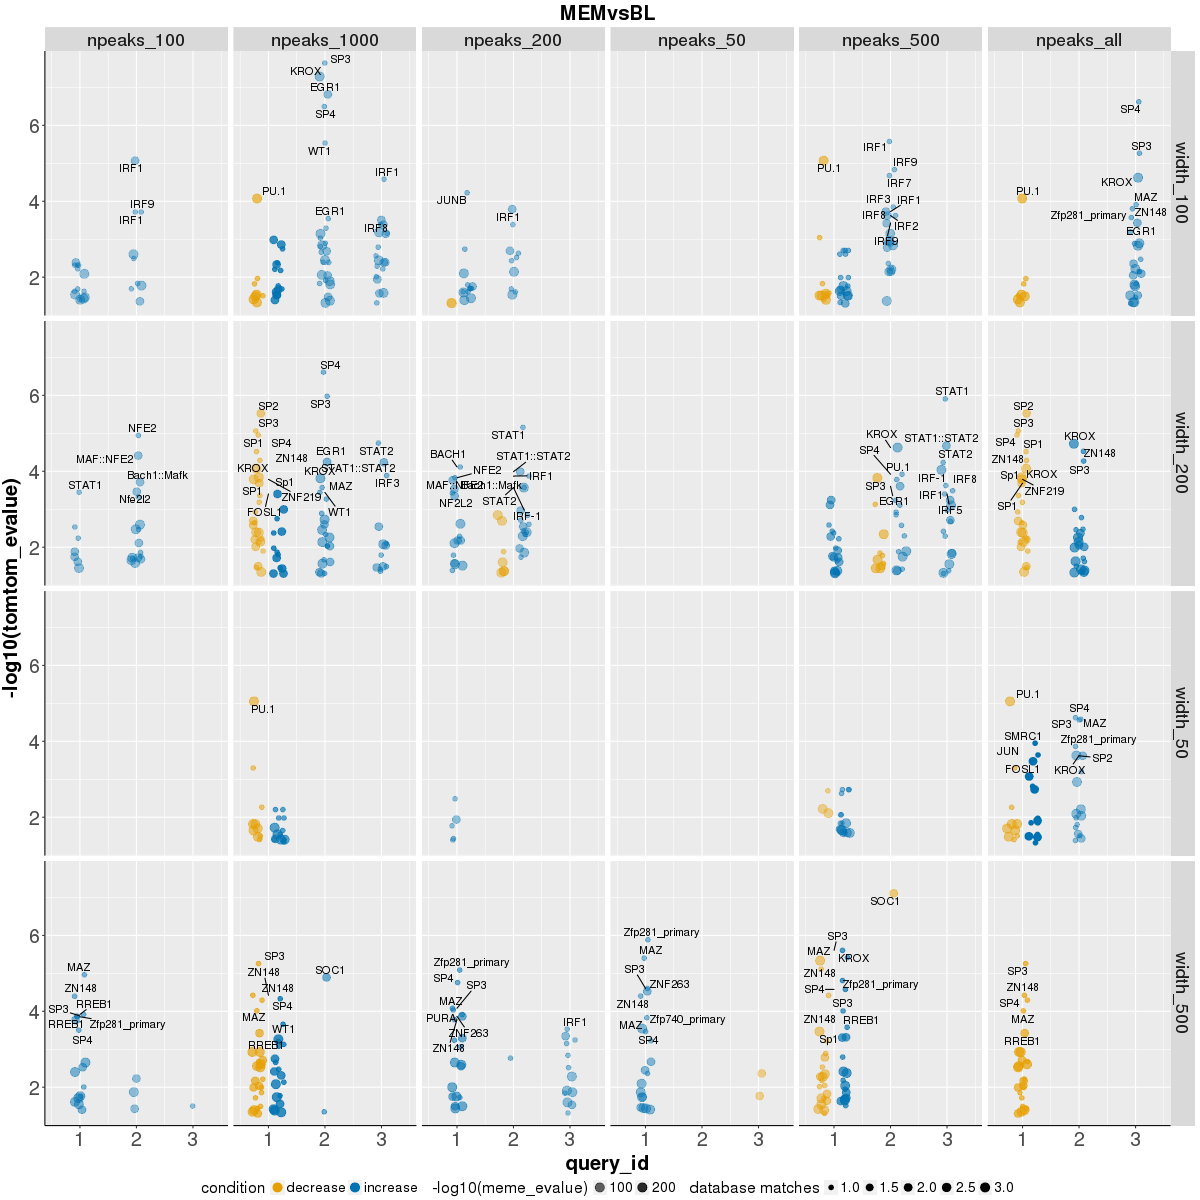

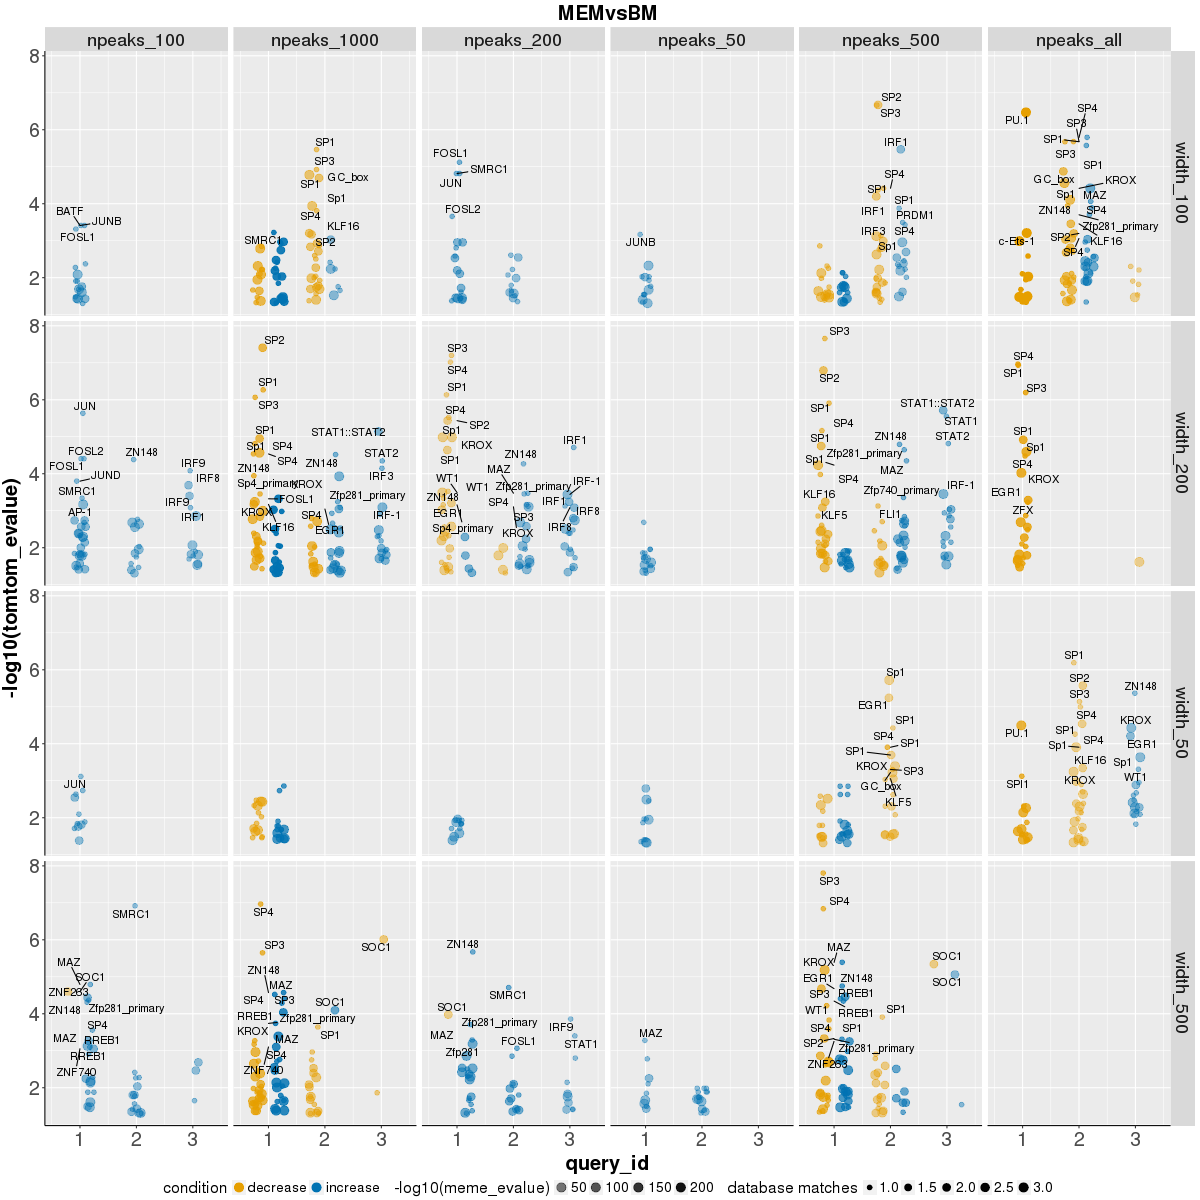

In [16]:
%%R -i meme_graph -w 1200 -h 1200

for (comp in unique(meme_graph$DESeq2_comparison)){
    df <- subset(meme_graph, DESeq2_comparison == comp)

    p <- ggplot(df, aes(y=-log10(tomtom_evalue), x=query_id, alpha=-log10(meme_evalue), colour=condition)) +
        geom_point(aes(size=database), position=position_jitterdodge()) + 
        scale_size(range=c(2,4), name="database matches") +
        scale_alpha(range=c(0.4,1)) +
        geom_text_repel(data=df[-log10(df$"tomtom_evalue") > 
                                       quantile(-log10(df$"tomtom_evalue"), 0.8, na.rm=T), ], 
                        aes(y=-log10(tomtom_evalue), x=query_id, label=motif_name), colour="black", alpha=1) +
        facet_grid(width ~ peaks) +
        theme(legend.position="bottom", legend.direction="horizontal") +
        scale_colour_manual(values=Palette) +
        guides(color=guide_legend(override.aes=list(size=4))) +
        guides(alpha=guide_legend(override.aes=list(size=4)))  +
        labs(title=comp)
    
    grid.arrange(p, ncol=1, nrow=1)
}

<br>
### Top TF Hits for Discovered Motifs 
- For significant motifs the top 5 significant TF matches are shown

In [21]:
tfs = meme_chip.groupby(["merge", "query_id", "DESeq2_comparison", "condition", "meme_evalue", "tomtom_evalue", "settings"])["motif_name"].unique()
tfs = pd.DataFrame(tfs)
tfs.reset_index(inplace=True)
tfs["motif_name"] = tfs["motif_name"].apply(lambda x:''.join(x))
tfs["query_id"] = tfs["query_id"].astype(str)
tfs = tfs.groupby("merge").head(5) # get top 5 db matches for each discovered motif

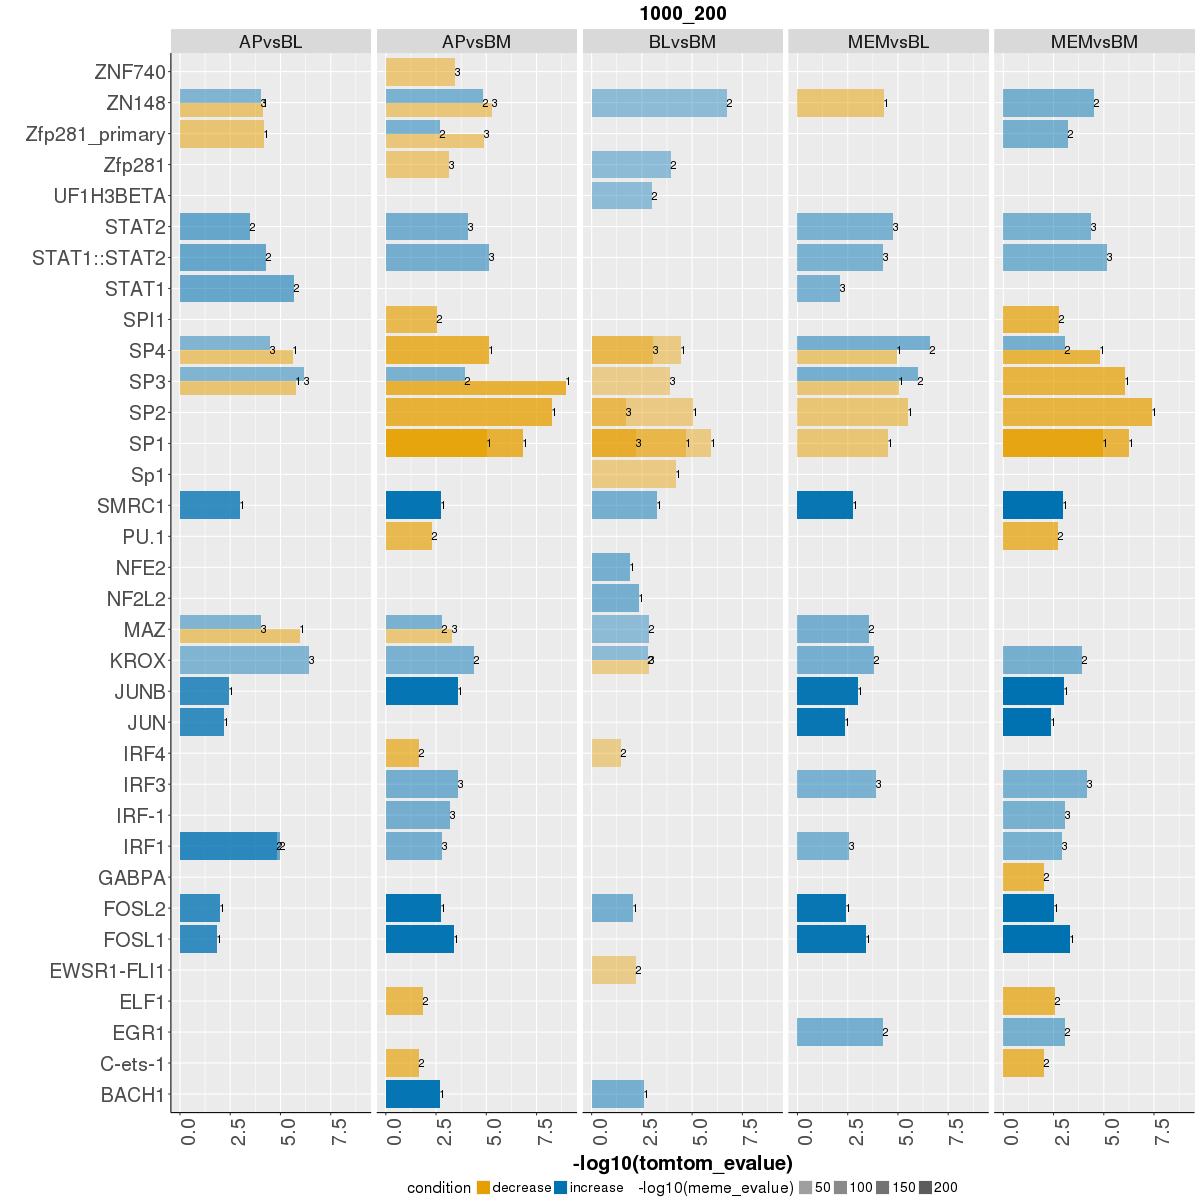

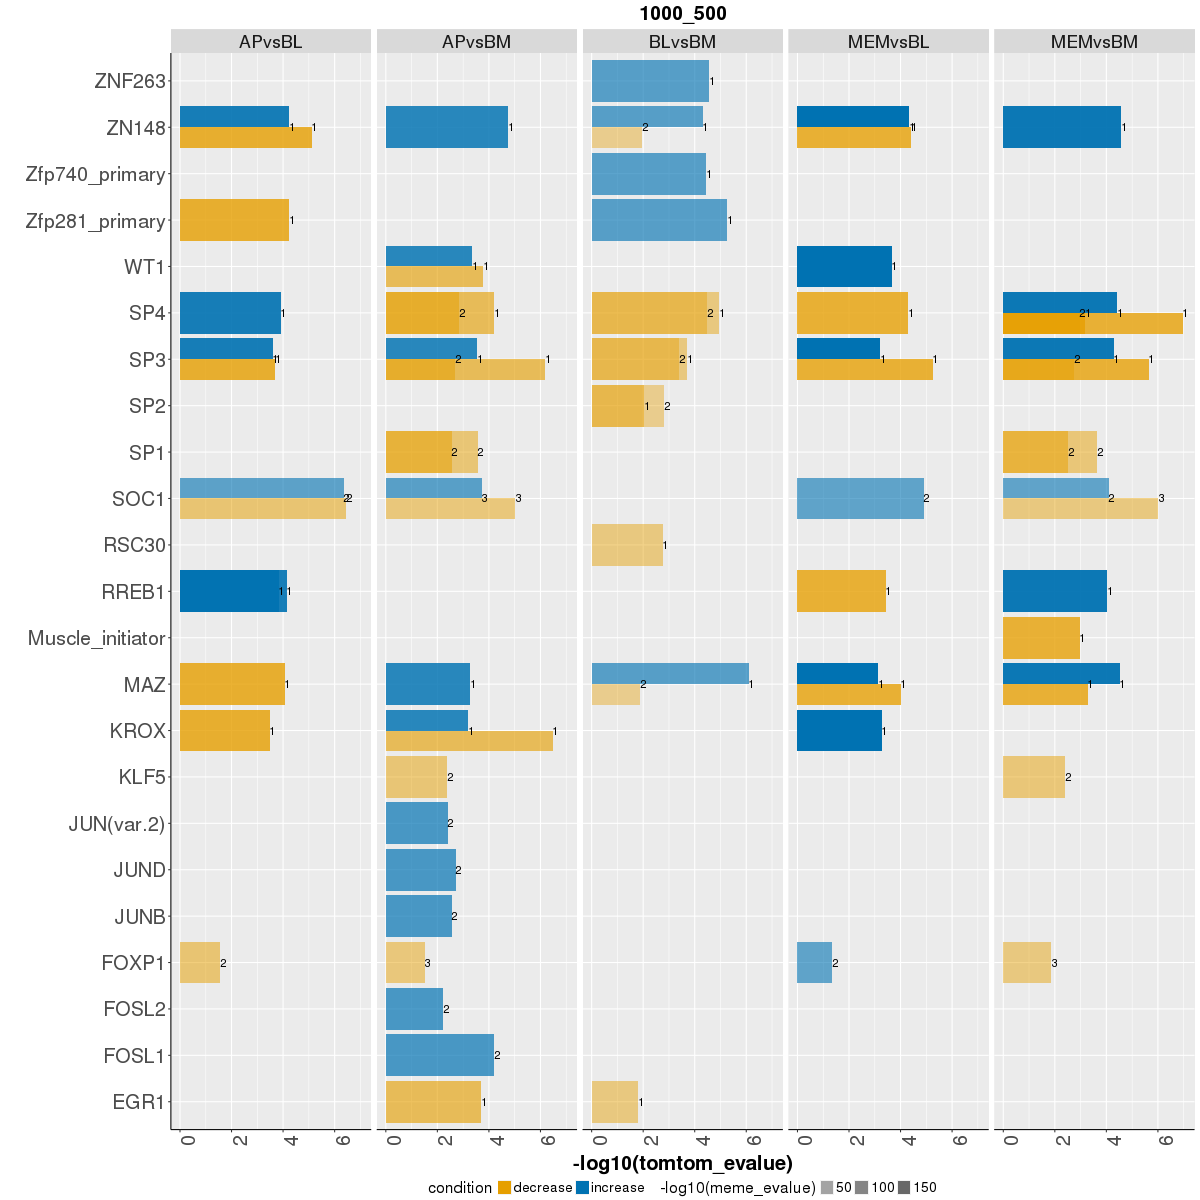

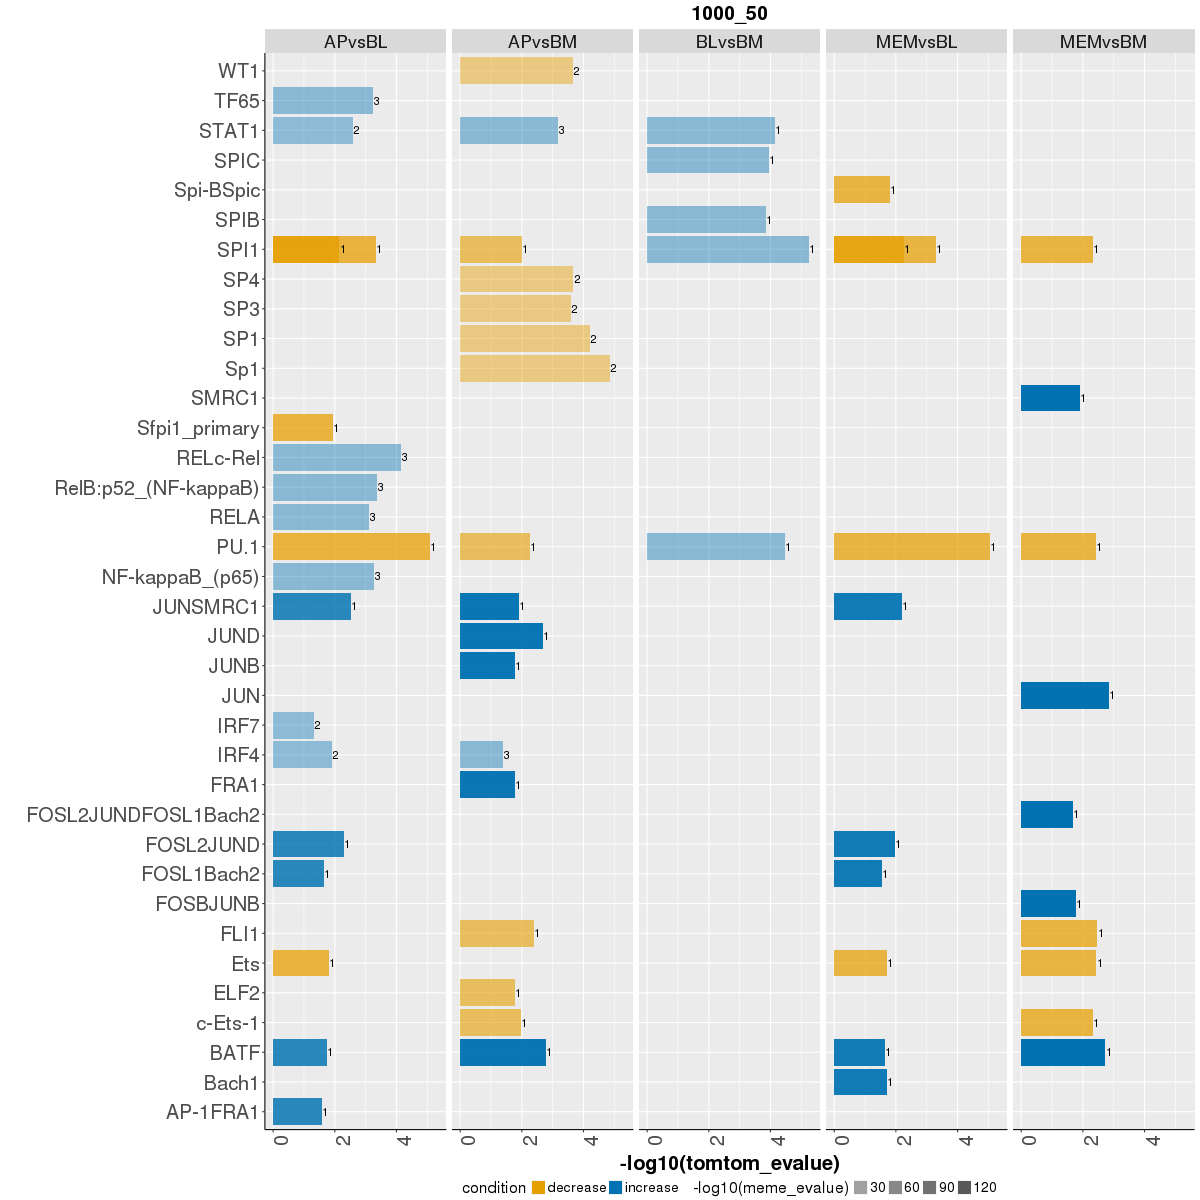

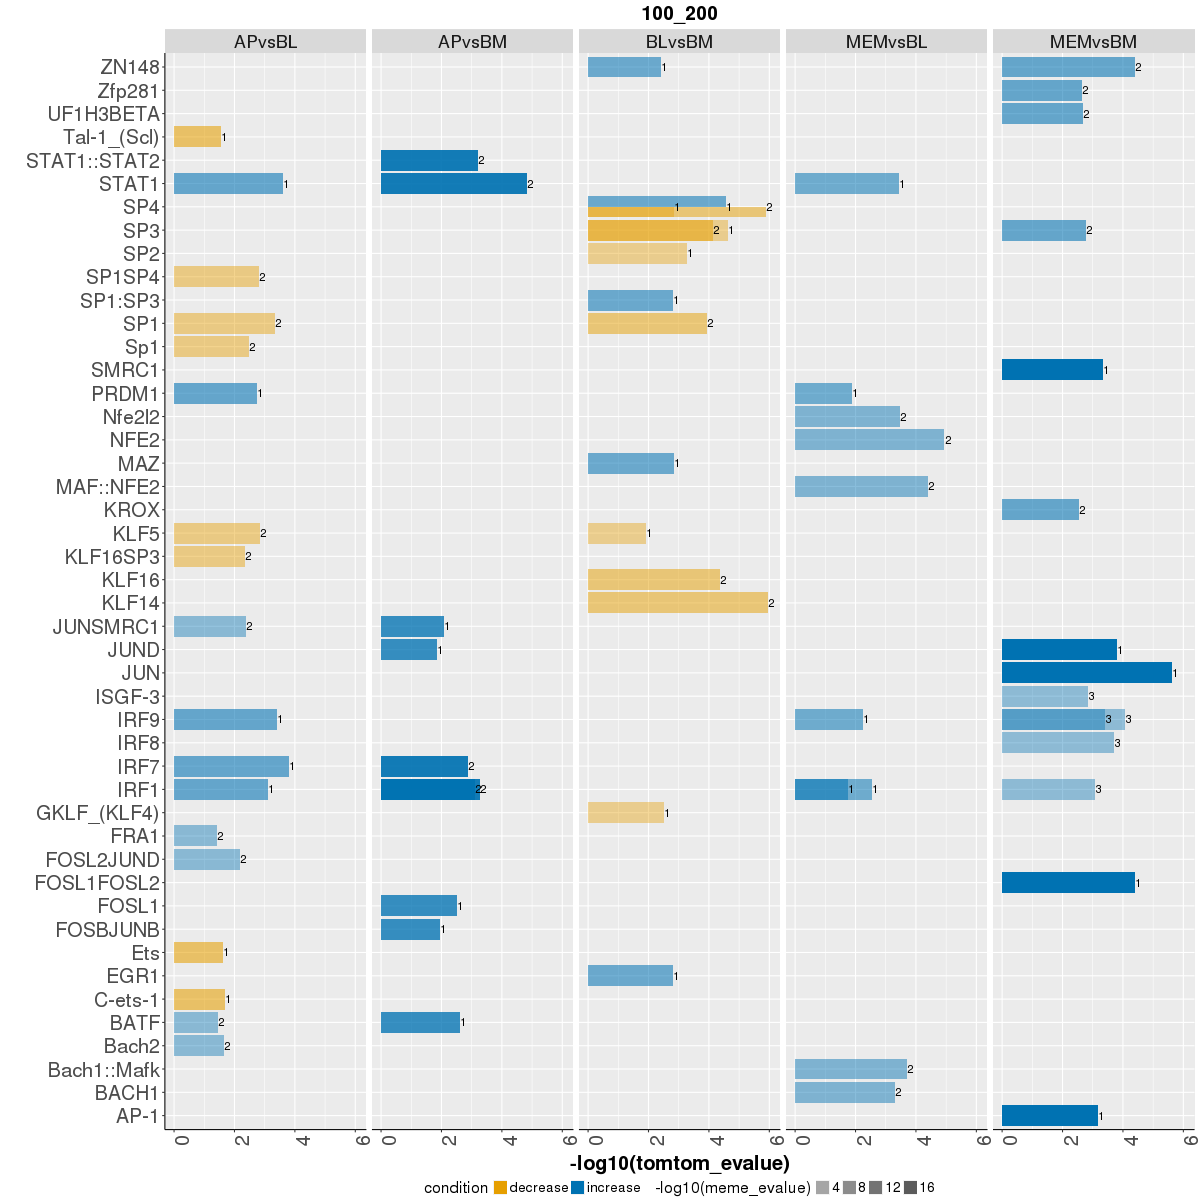

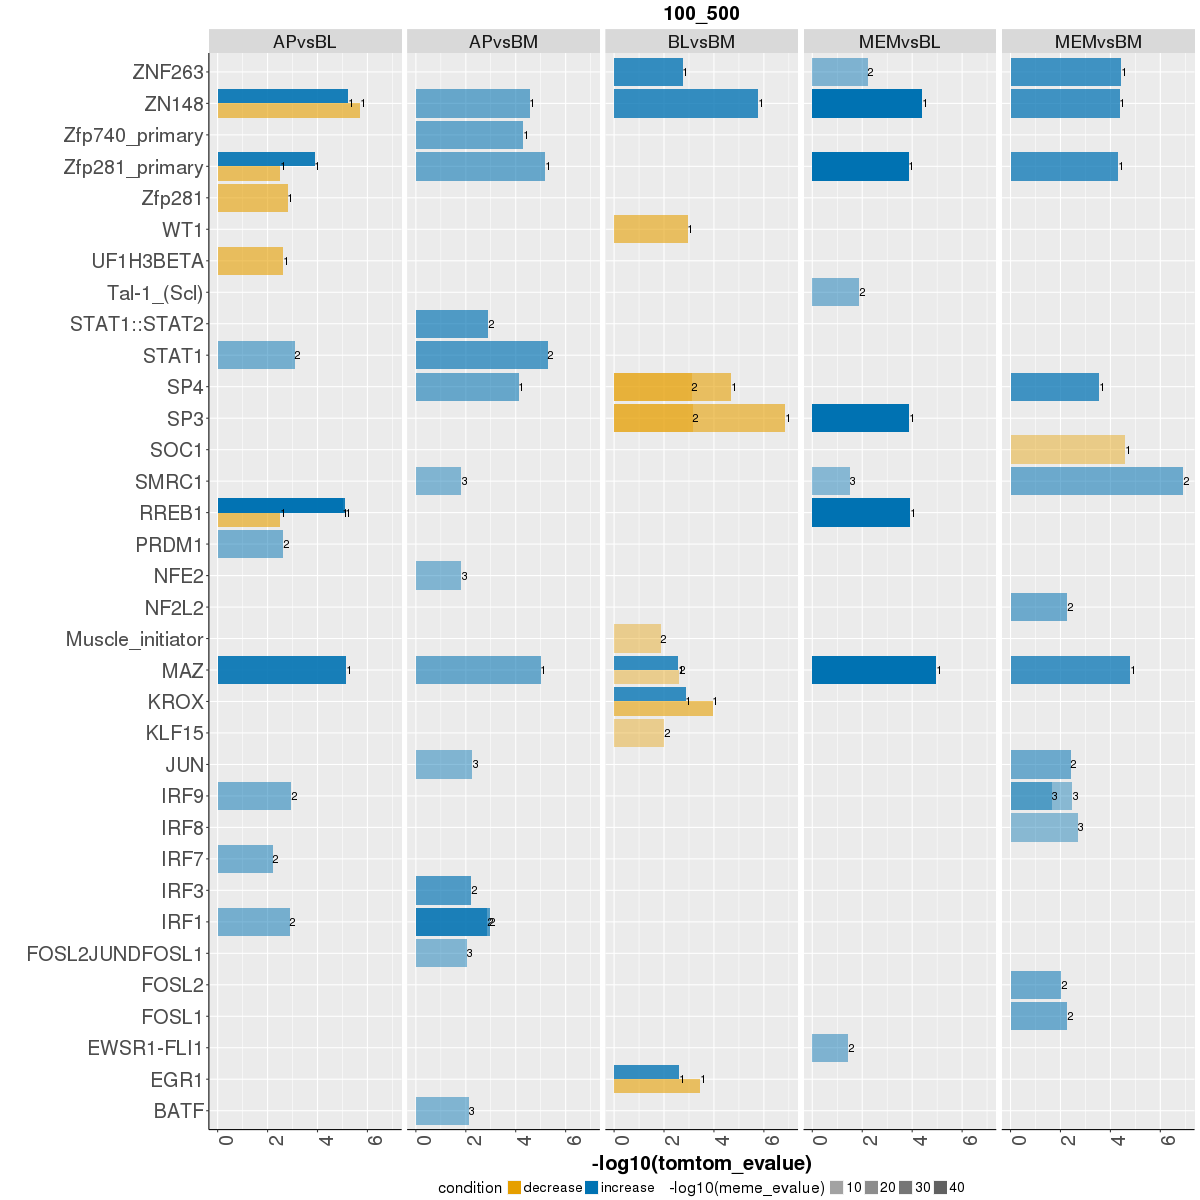

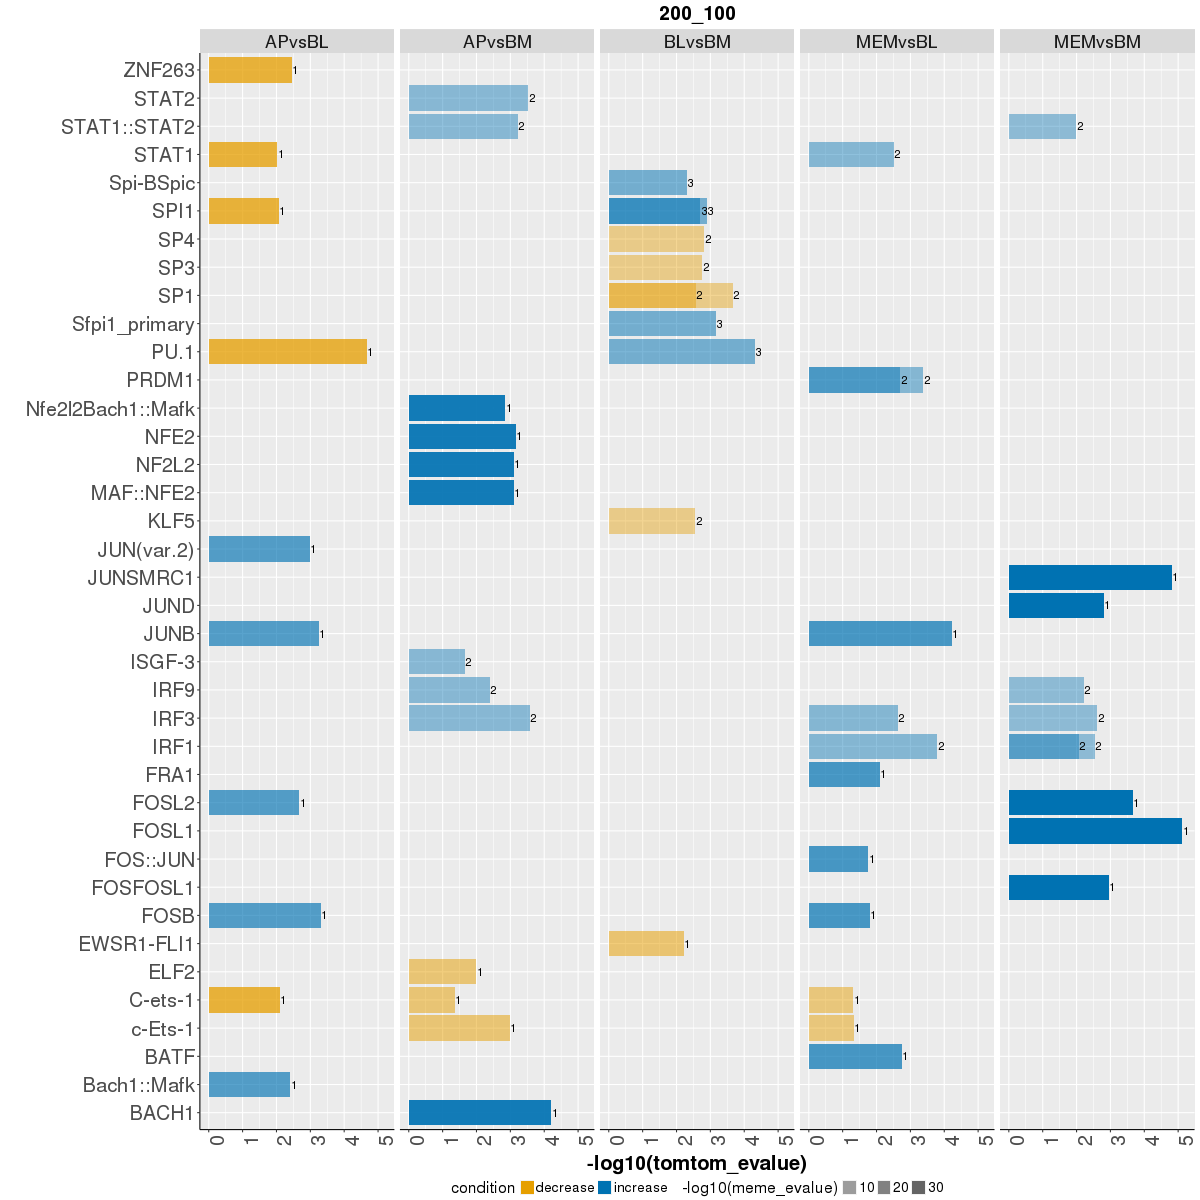

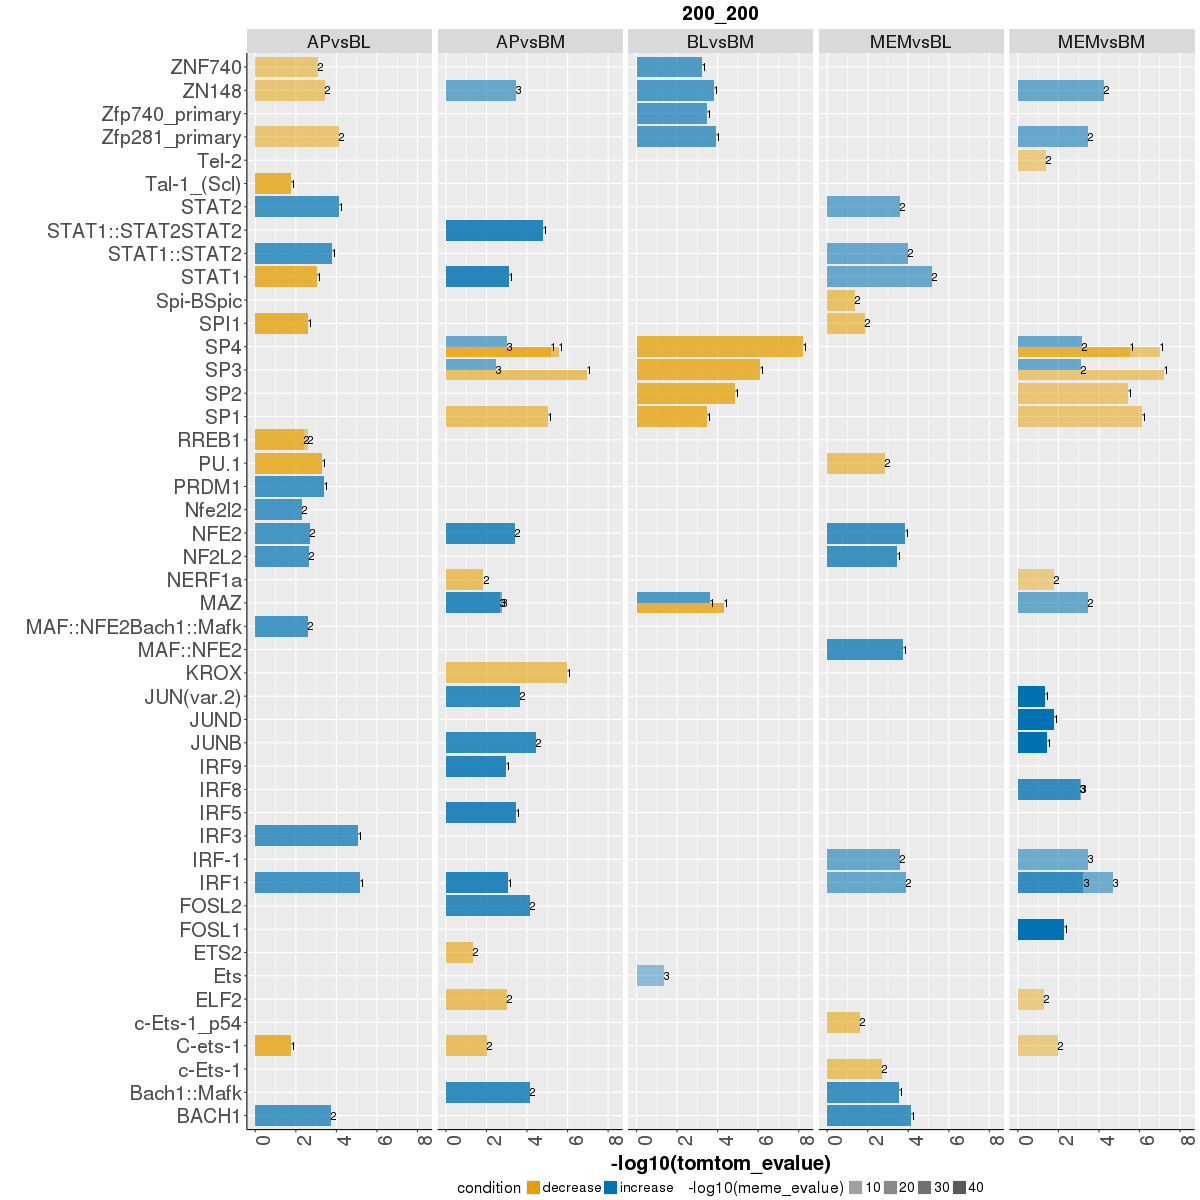

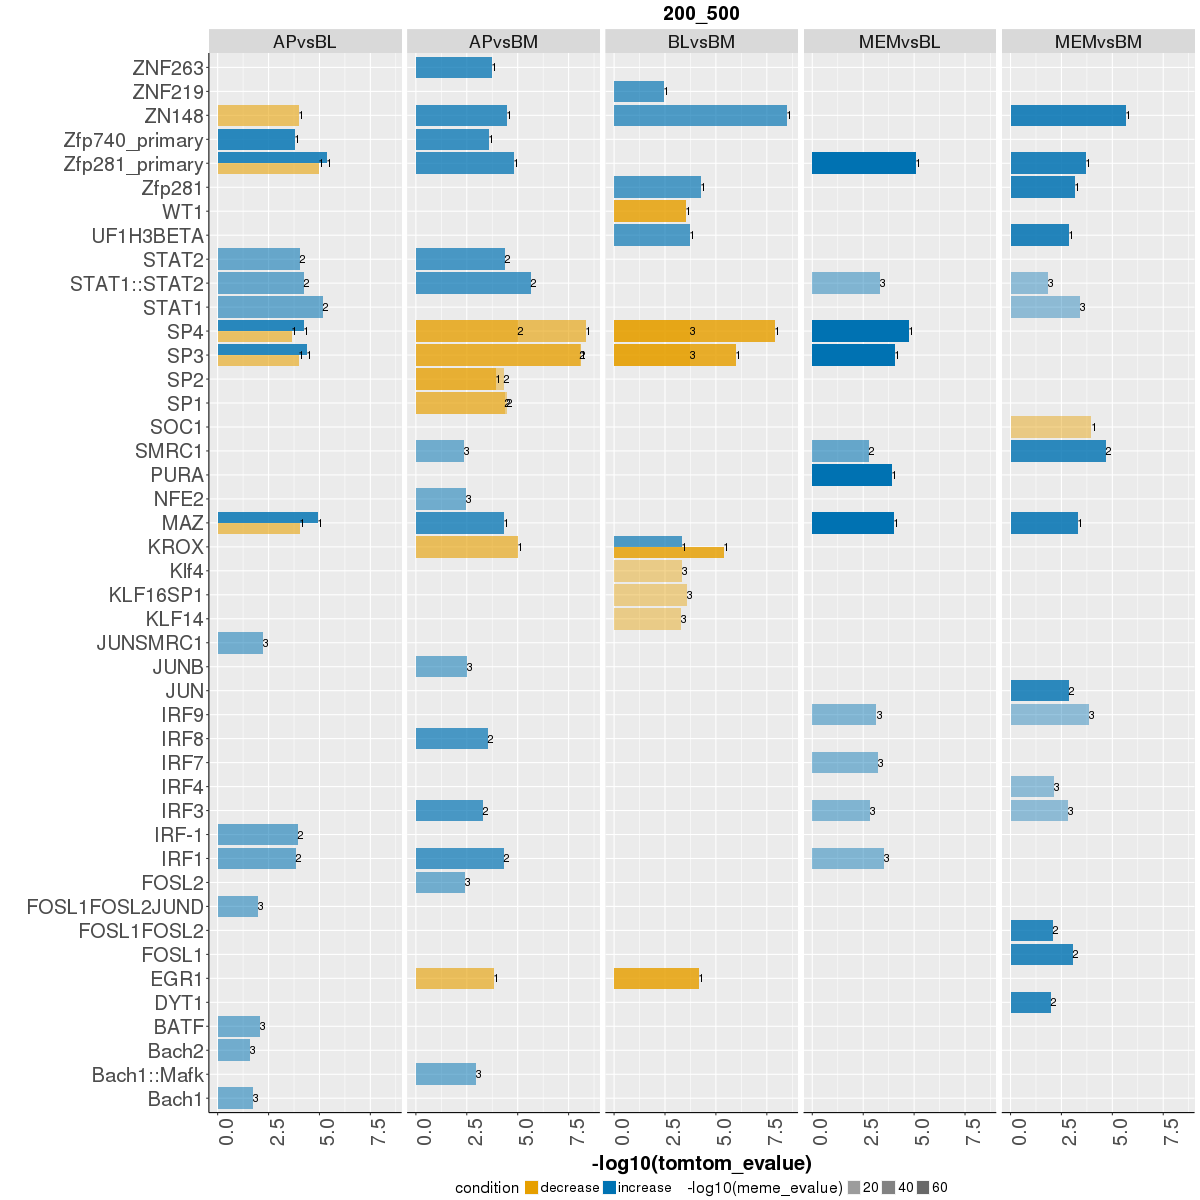

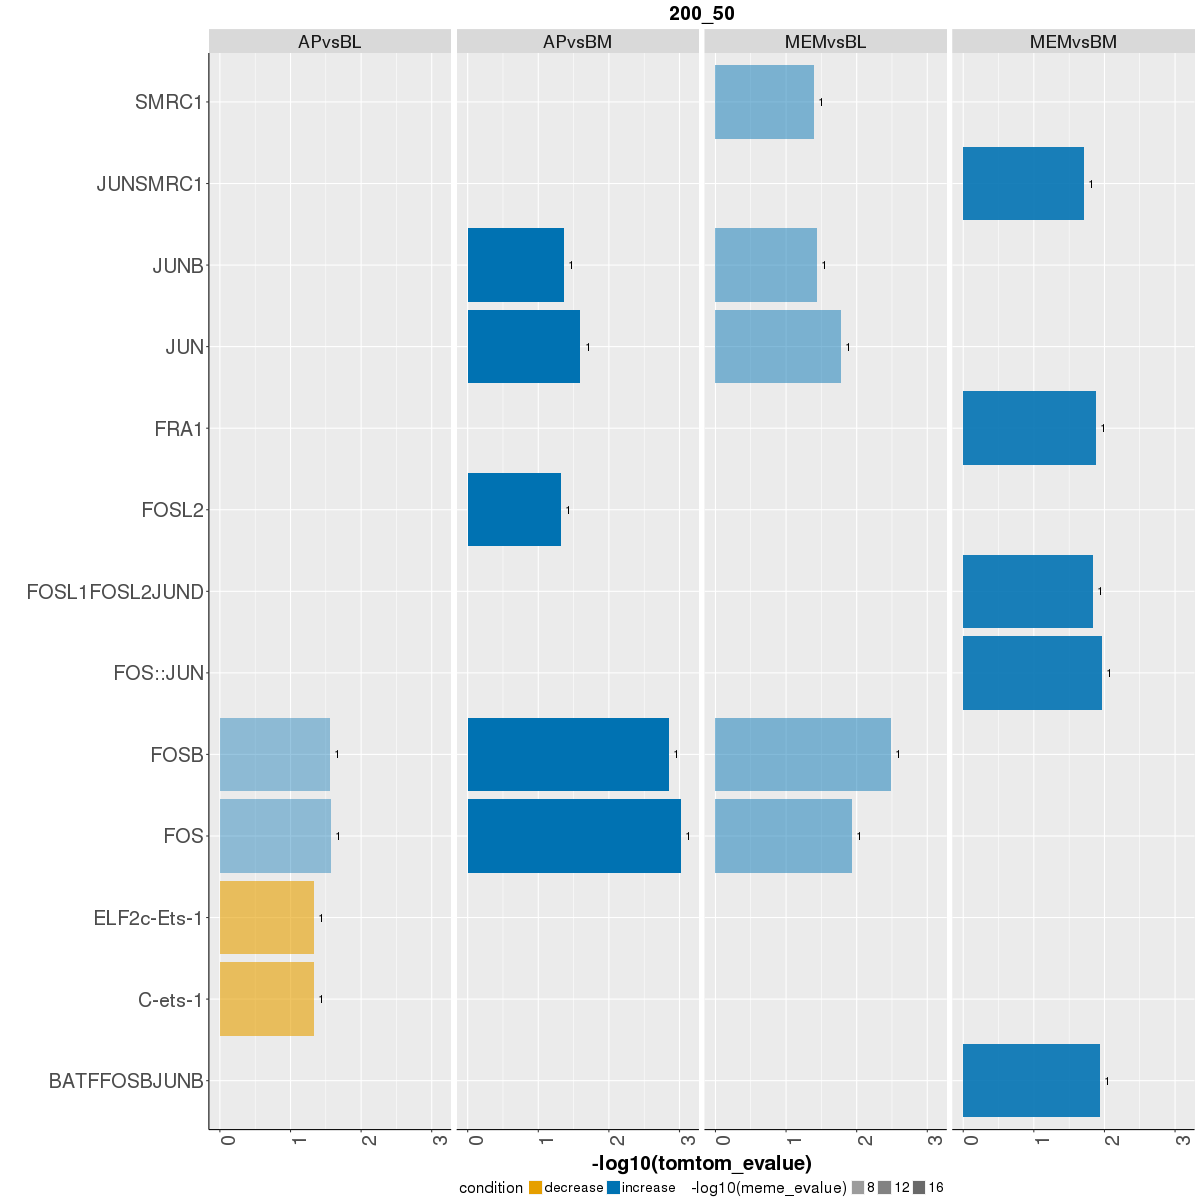

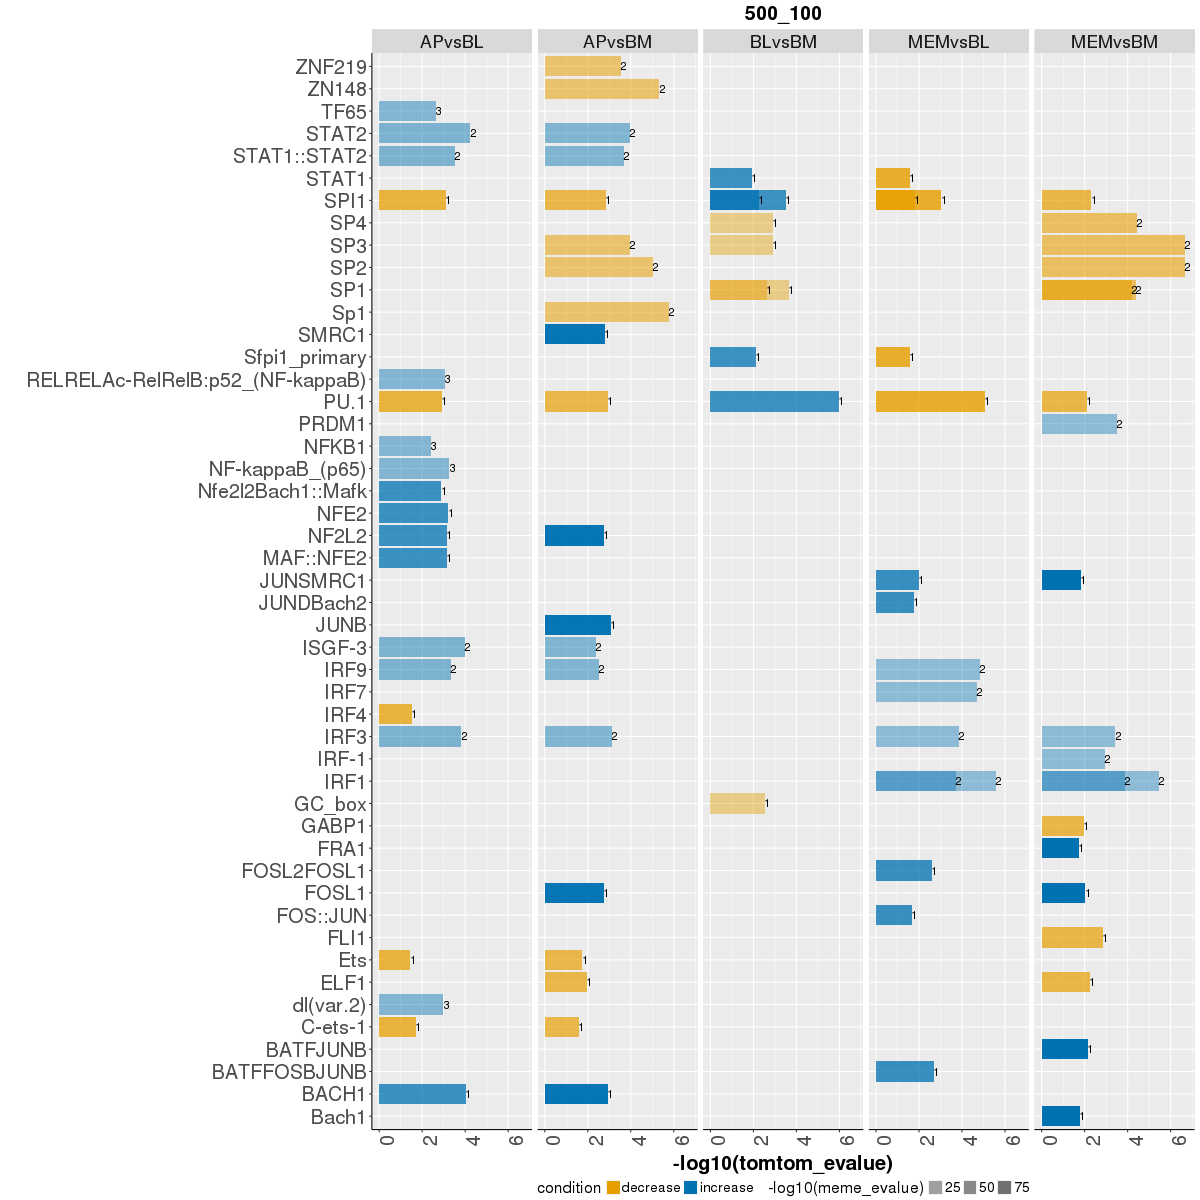

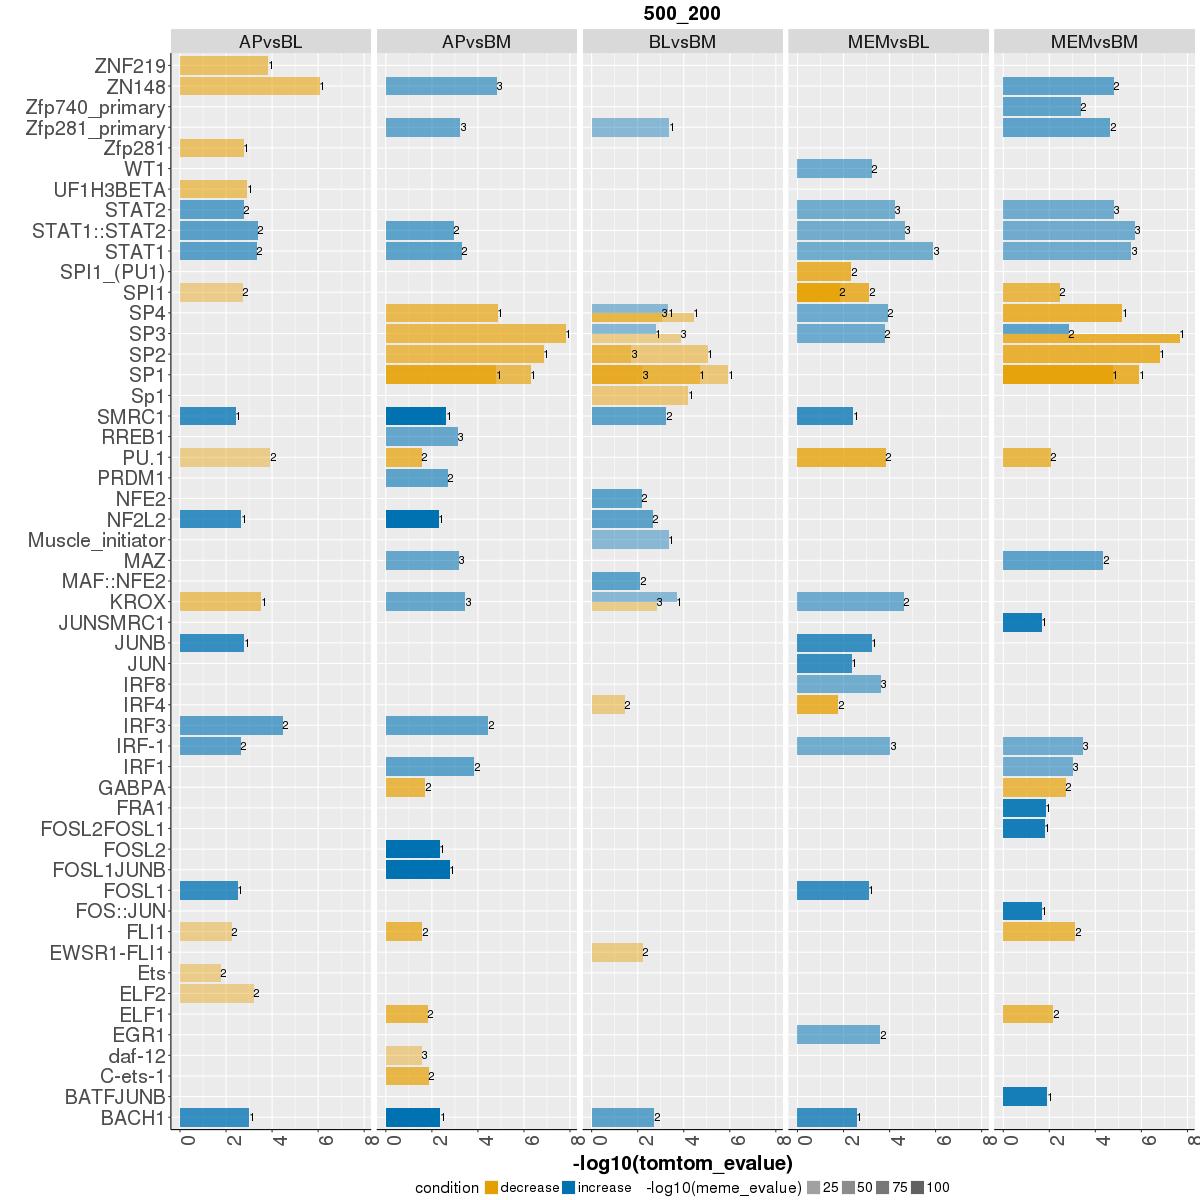

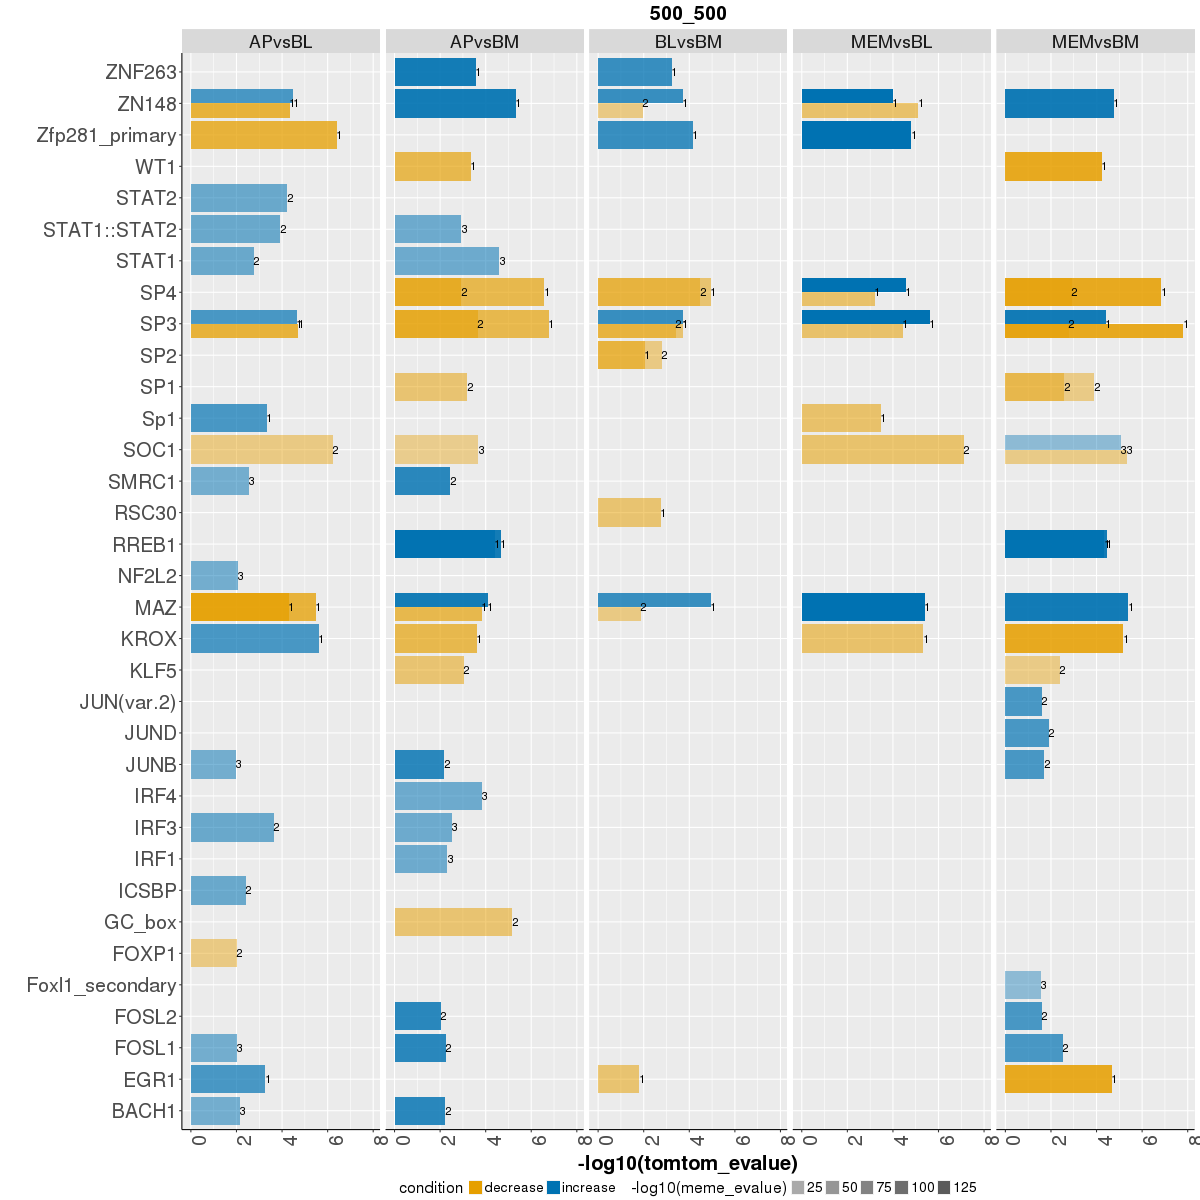

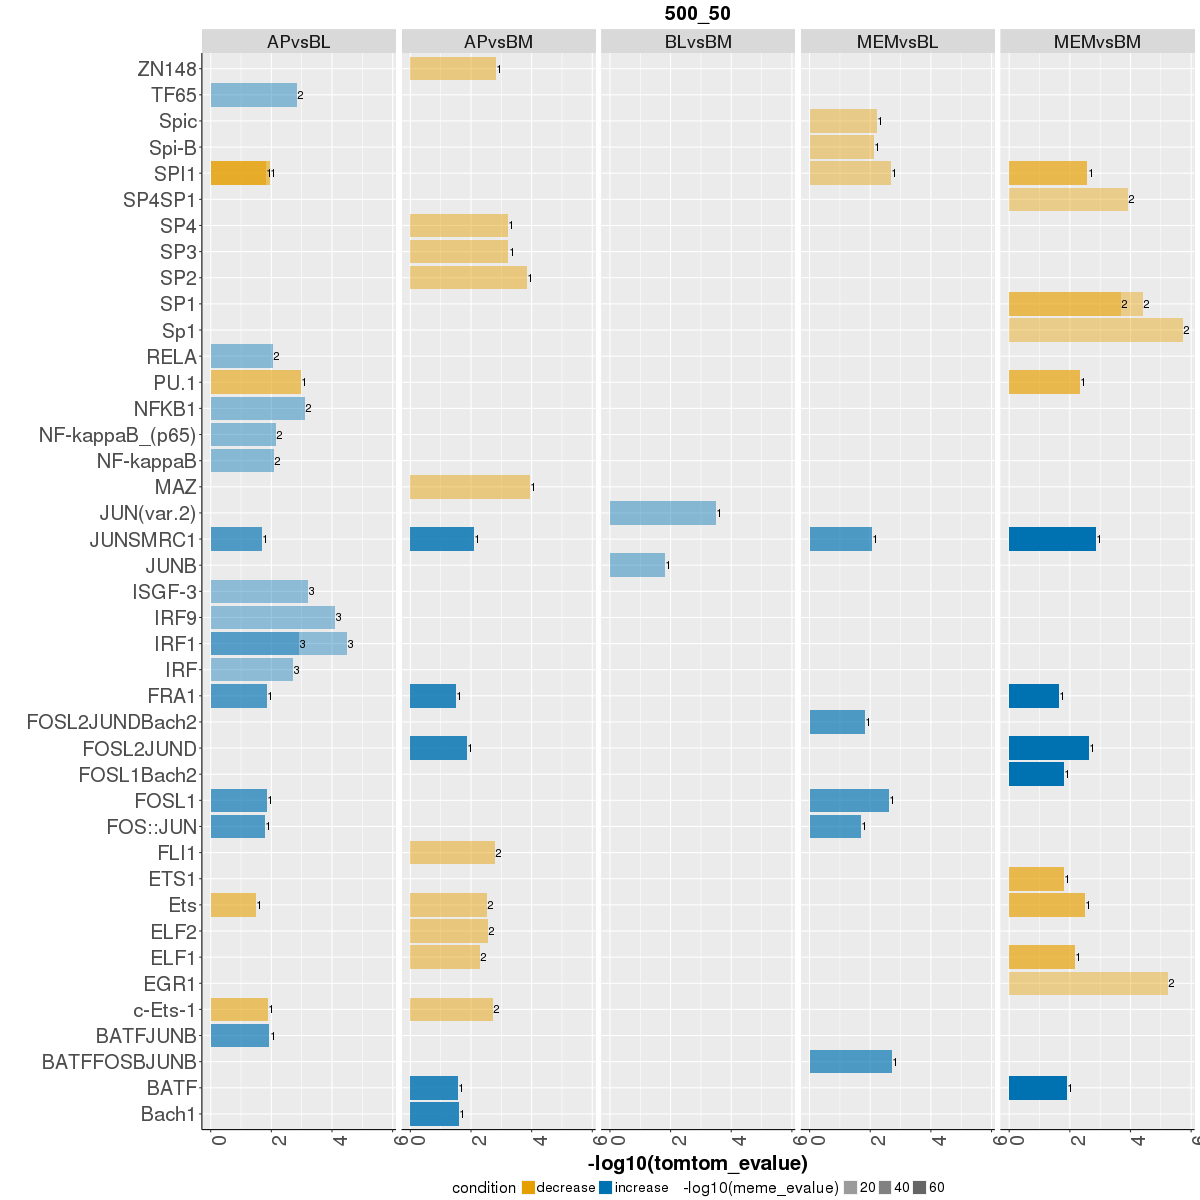

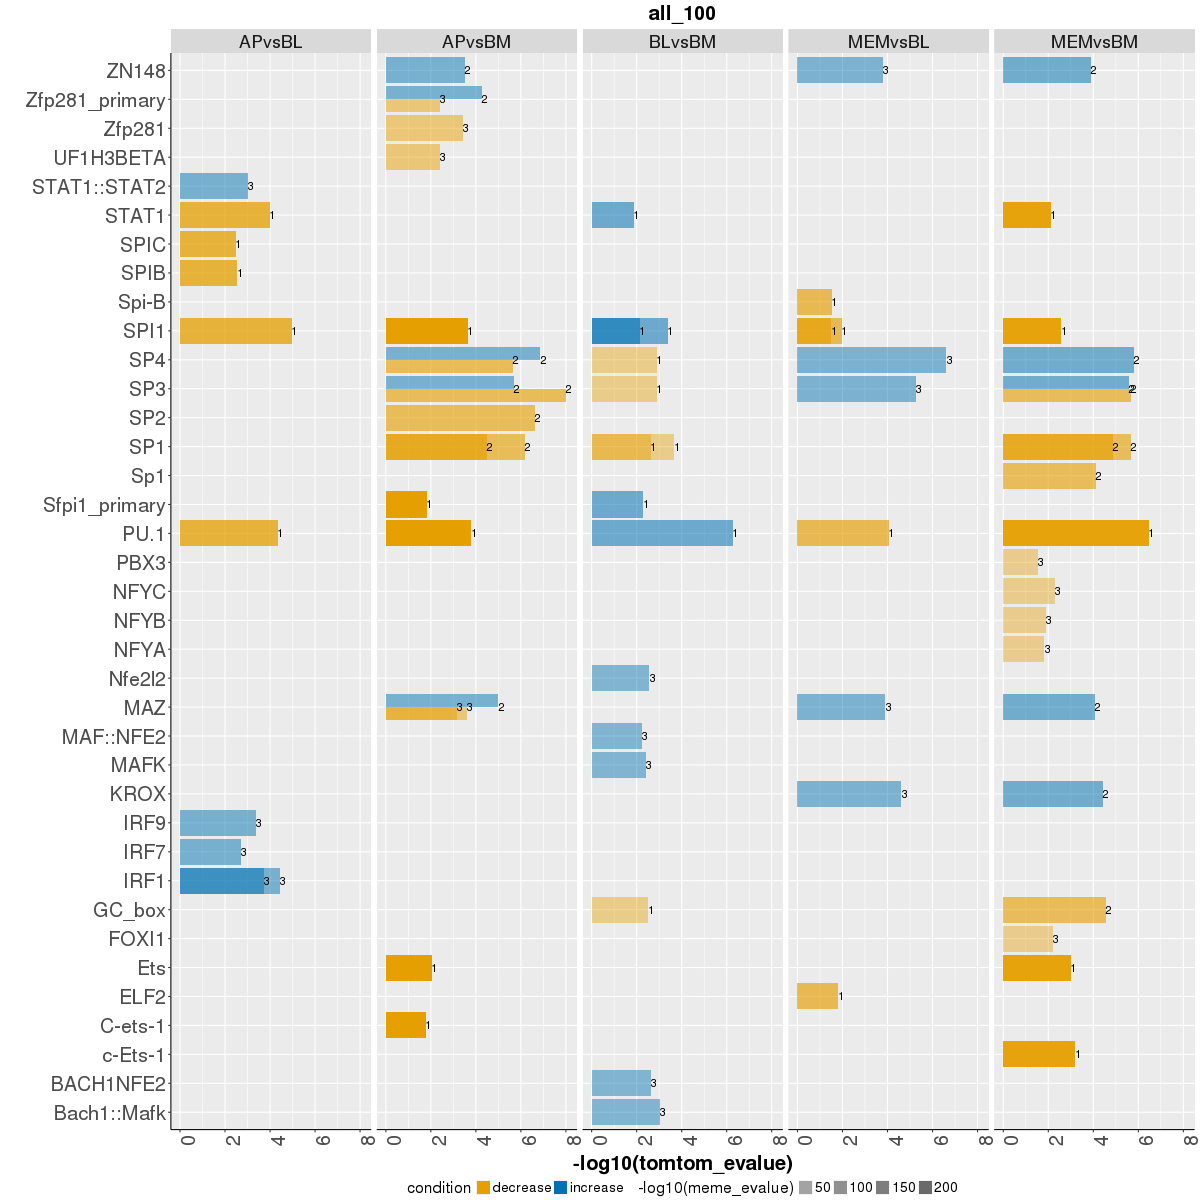

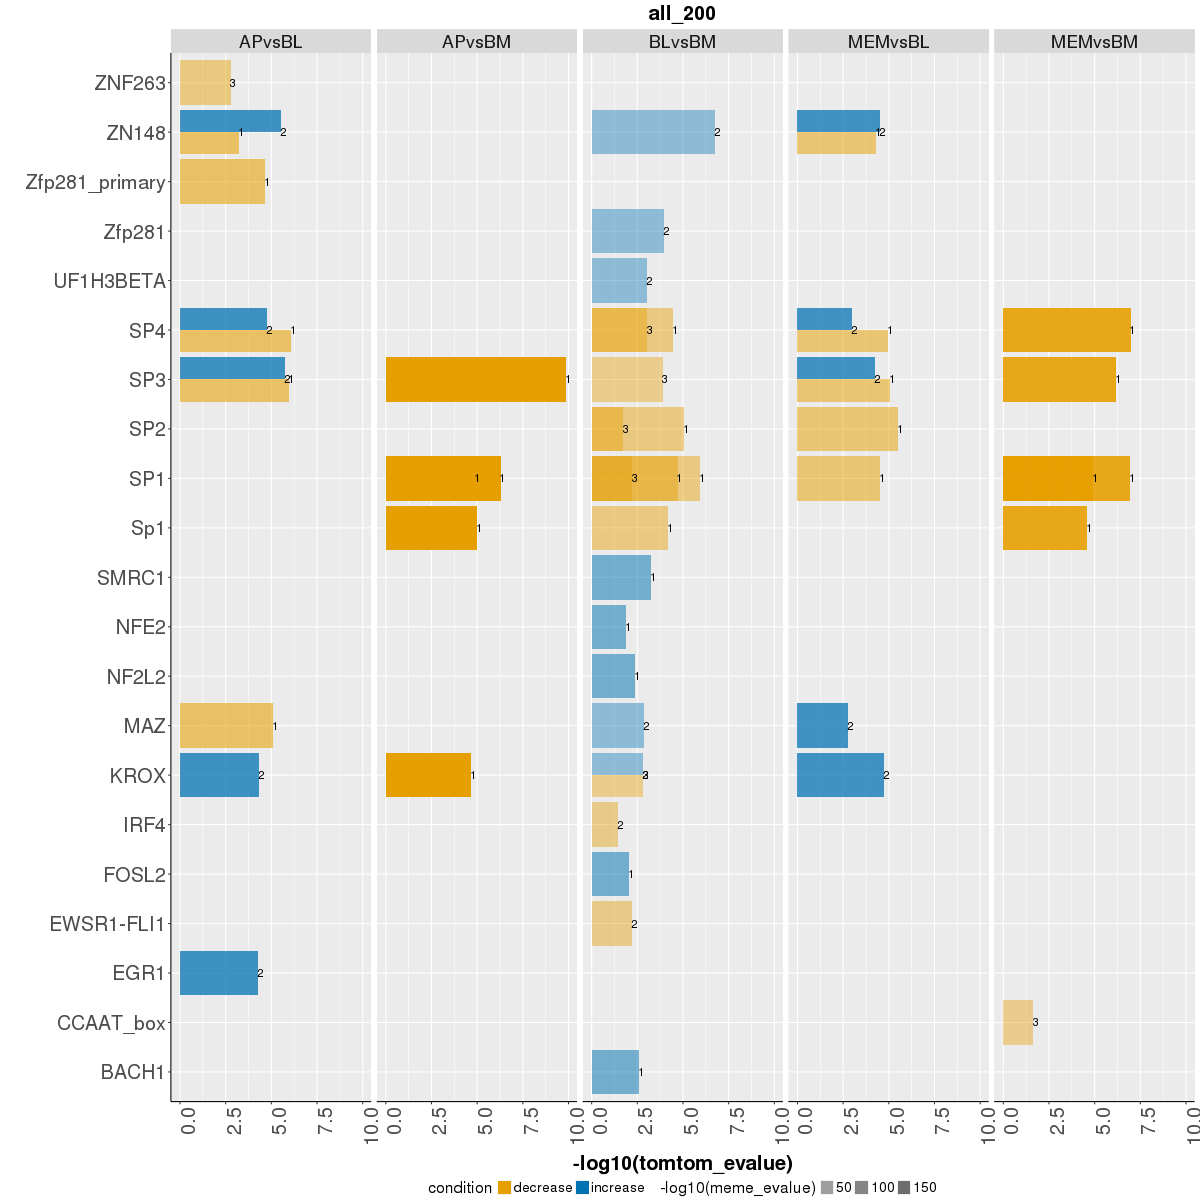

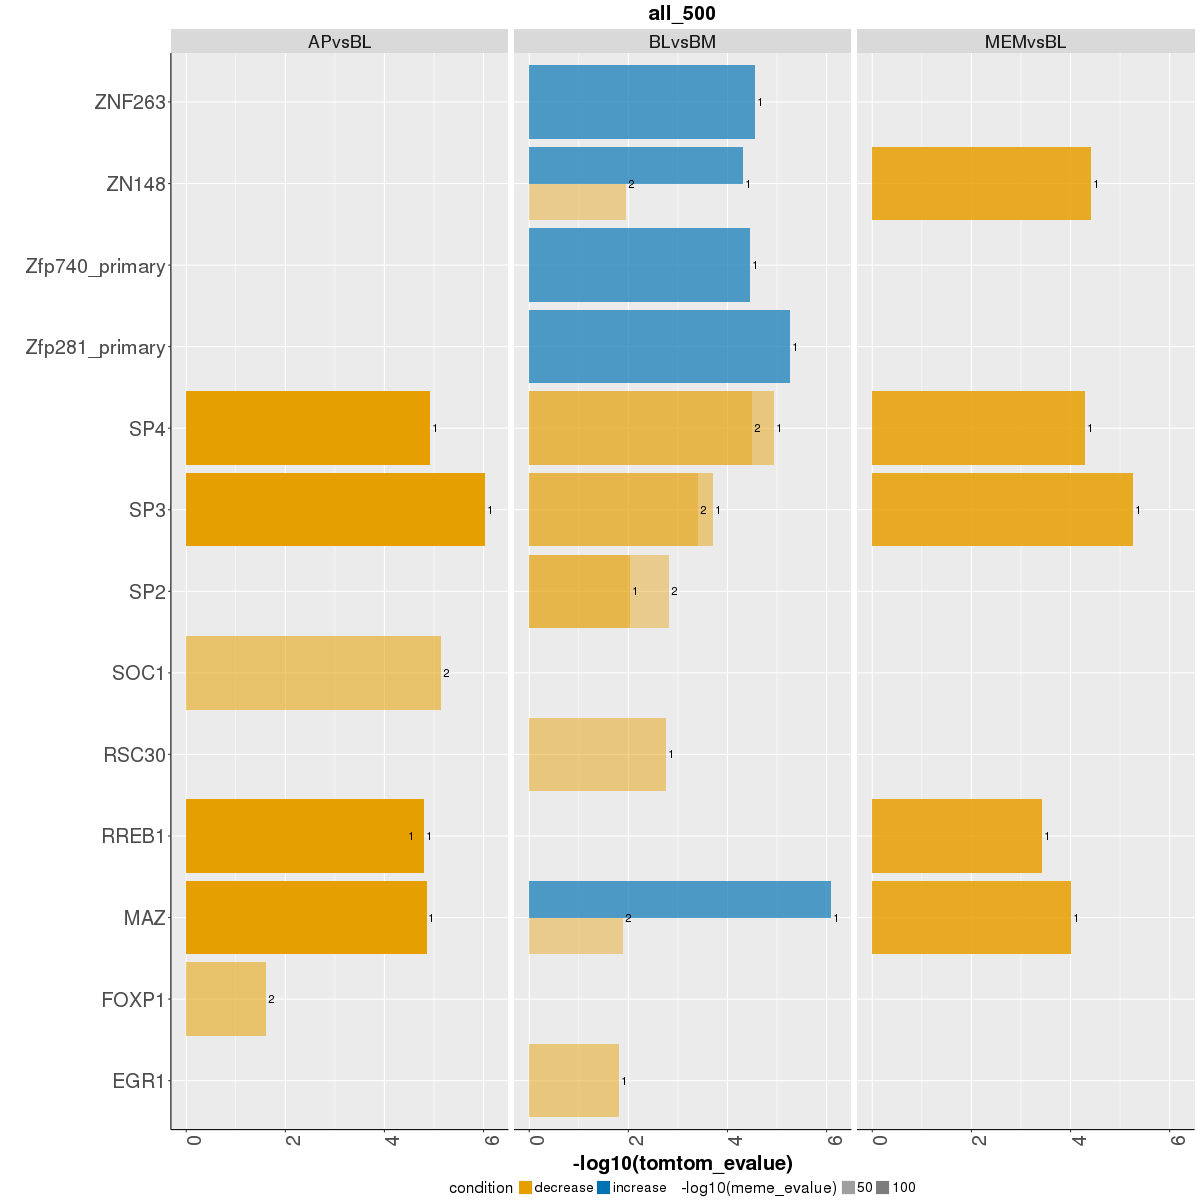

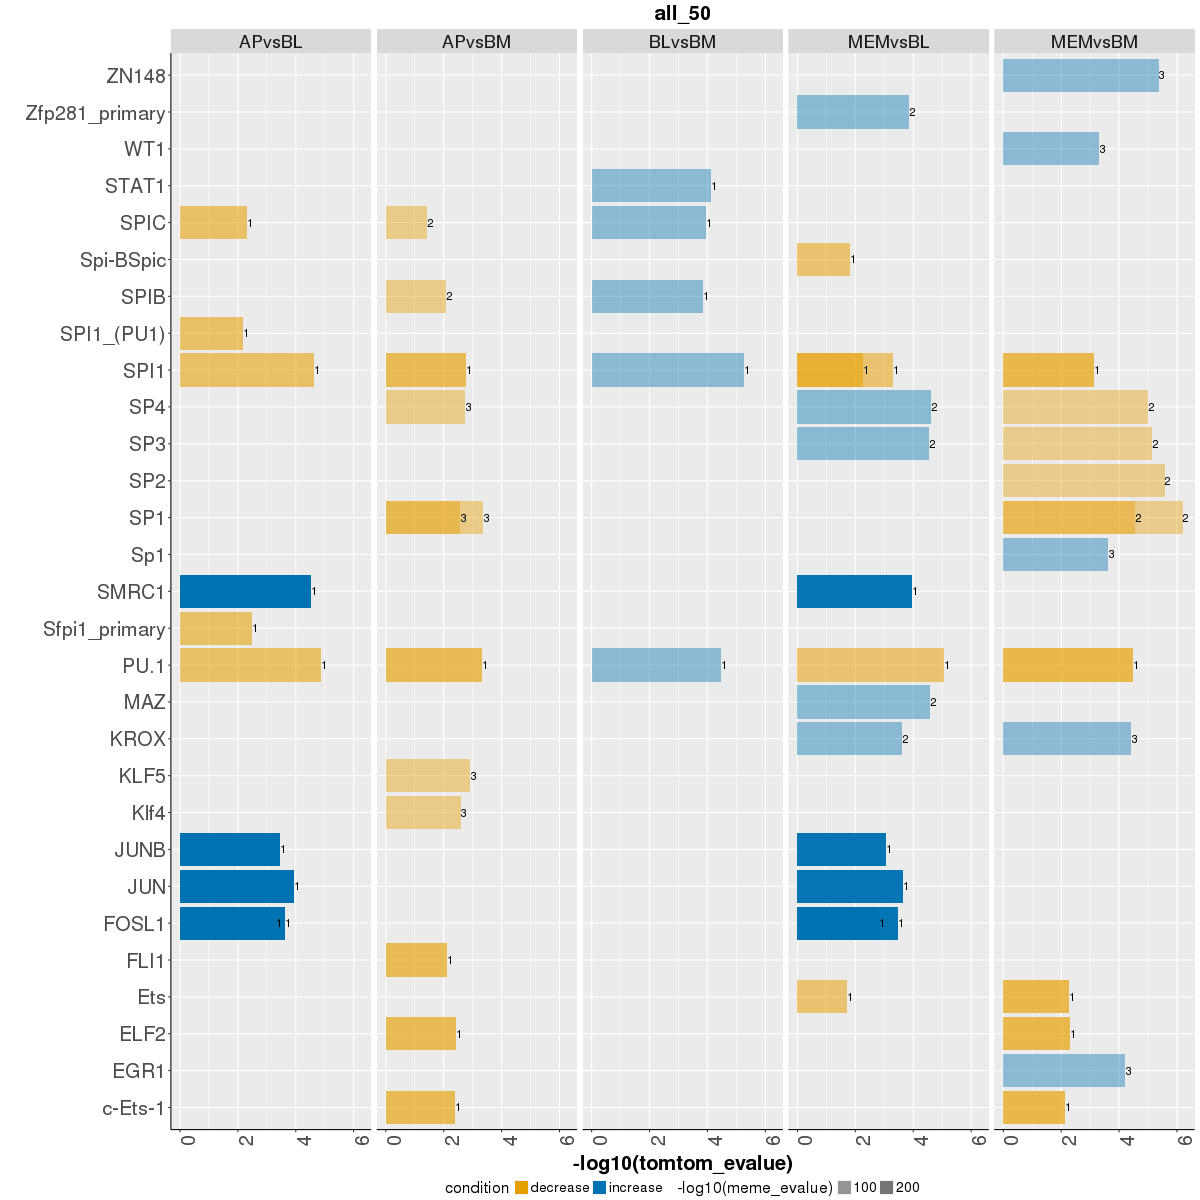

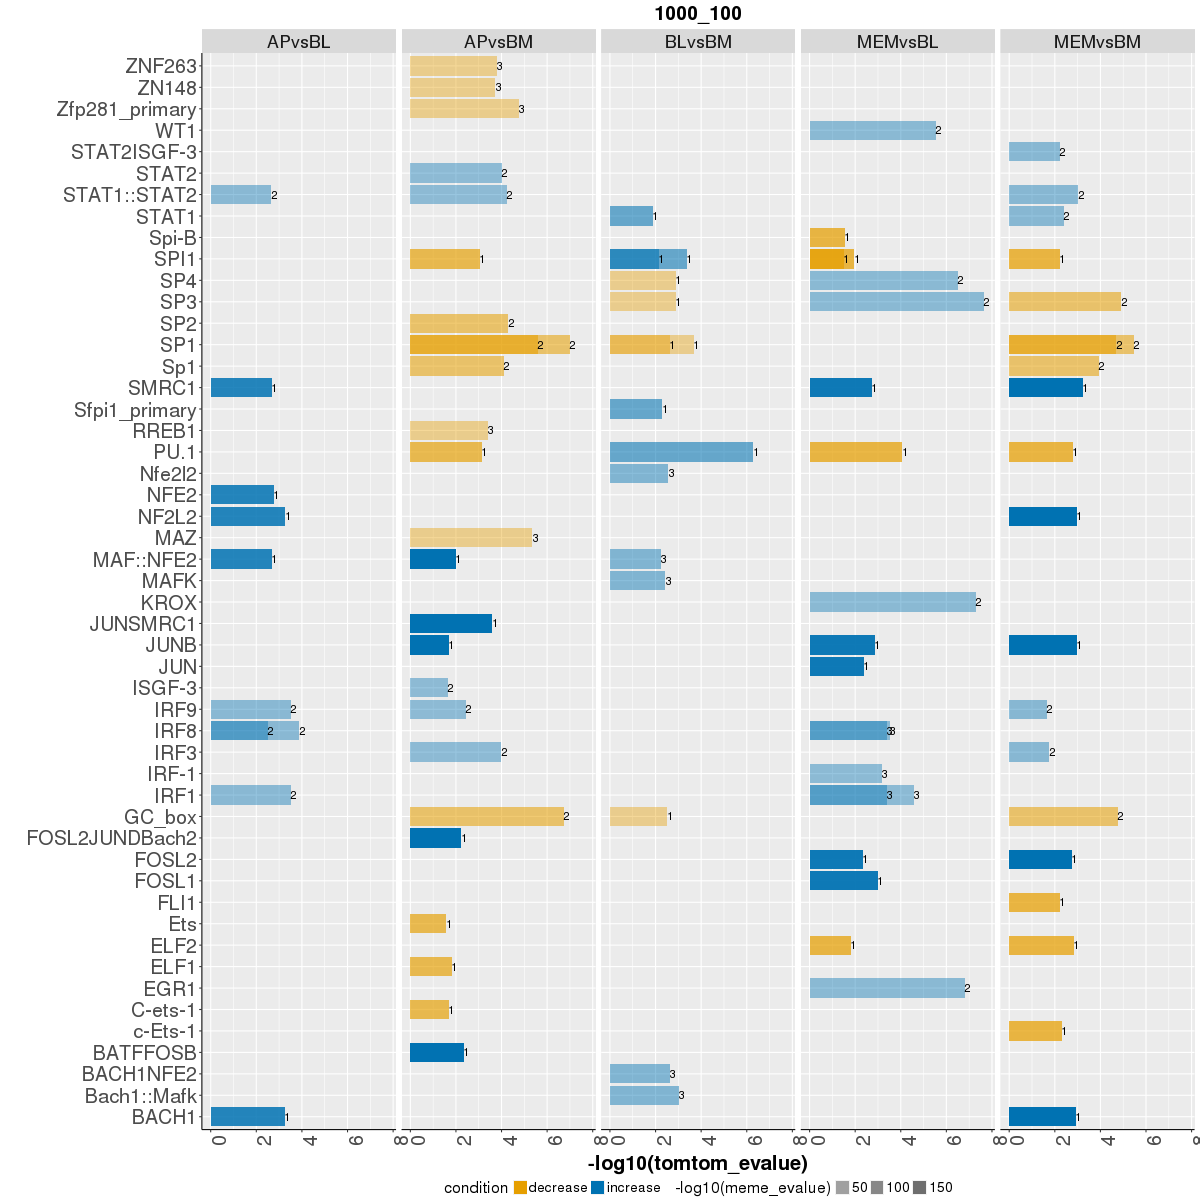

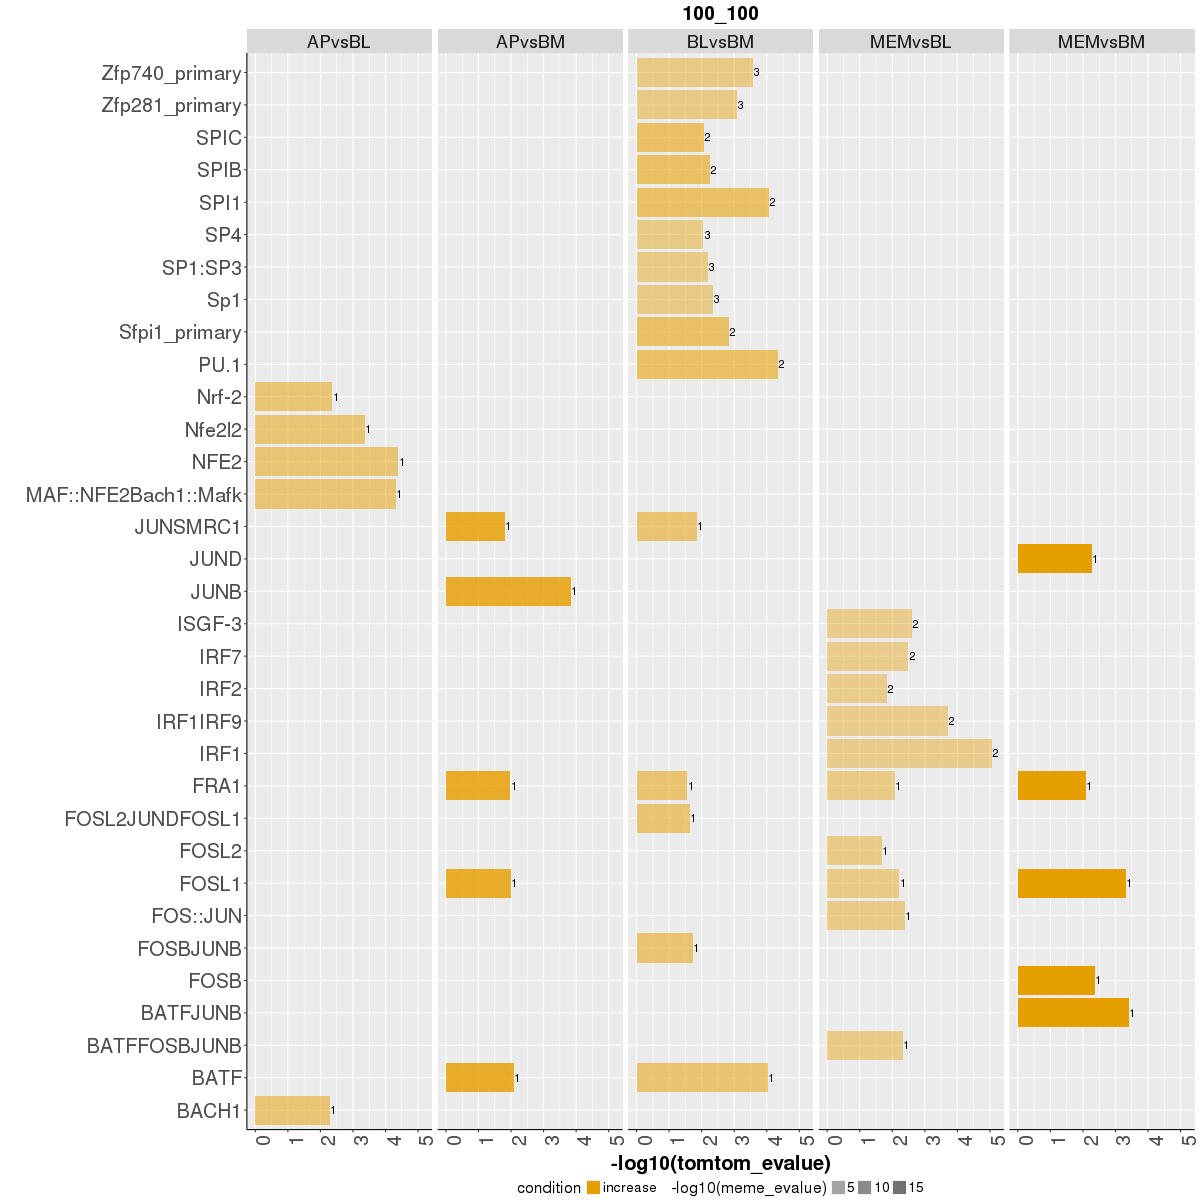

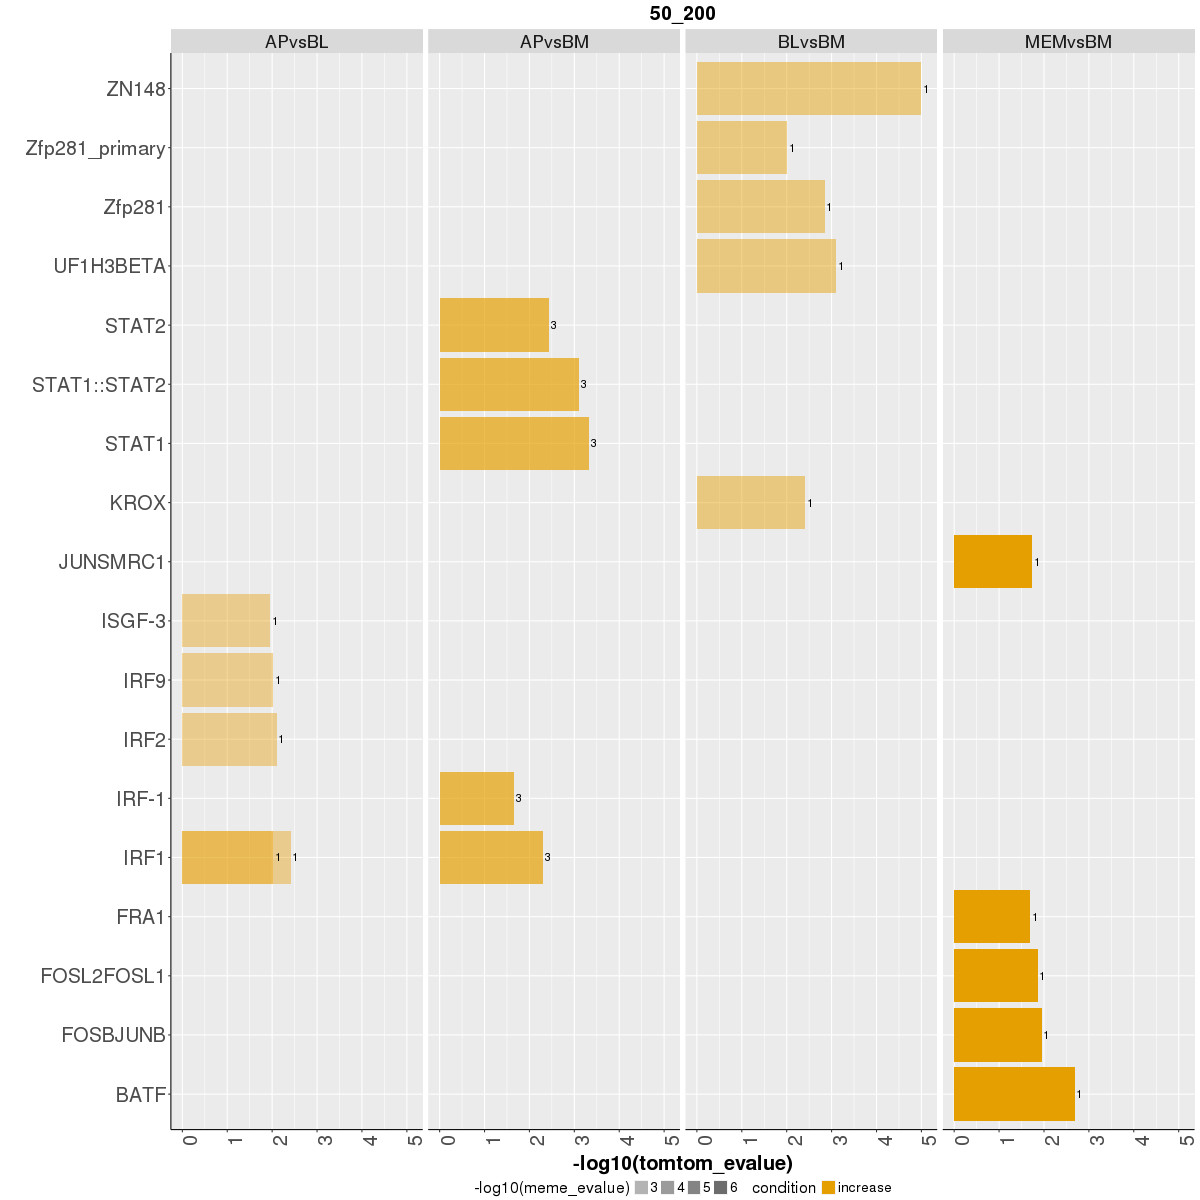

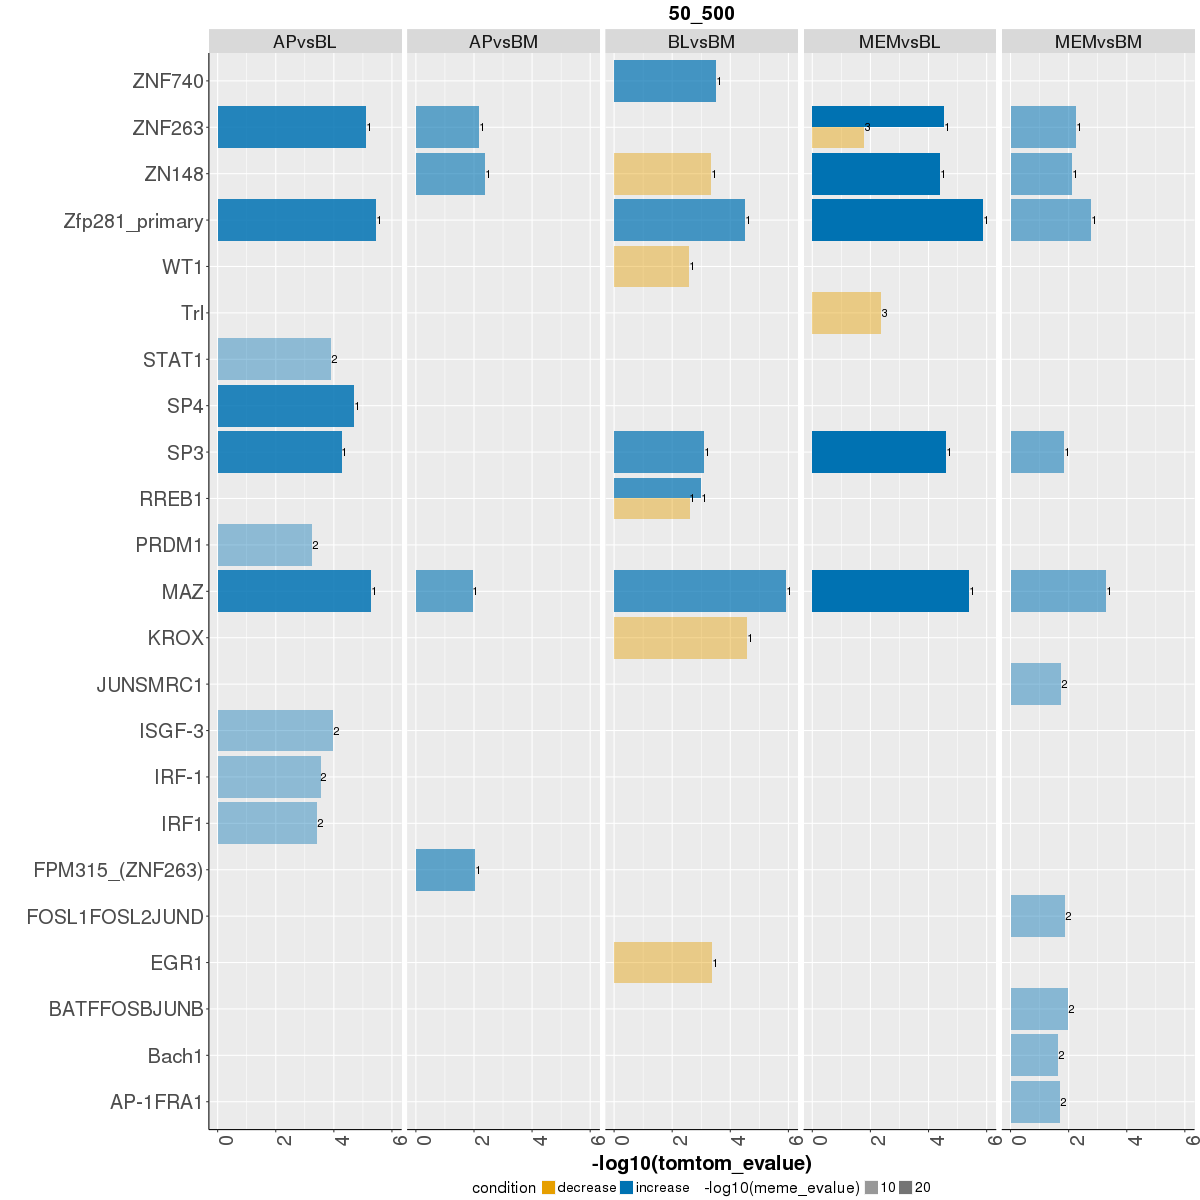

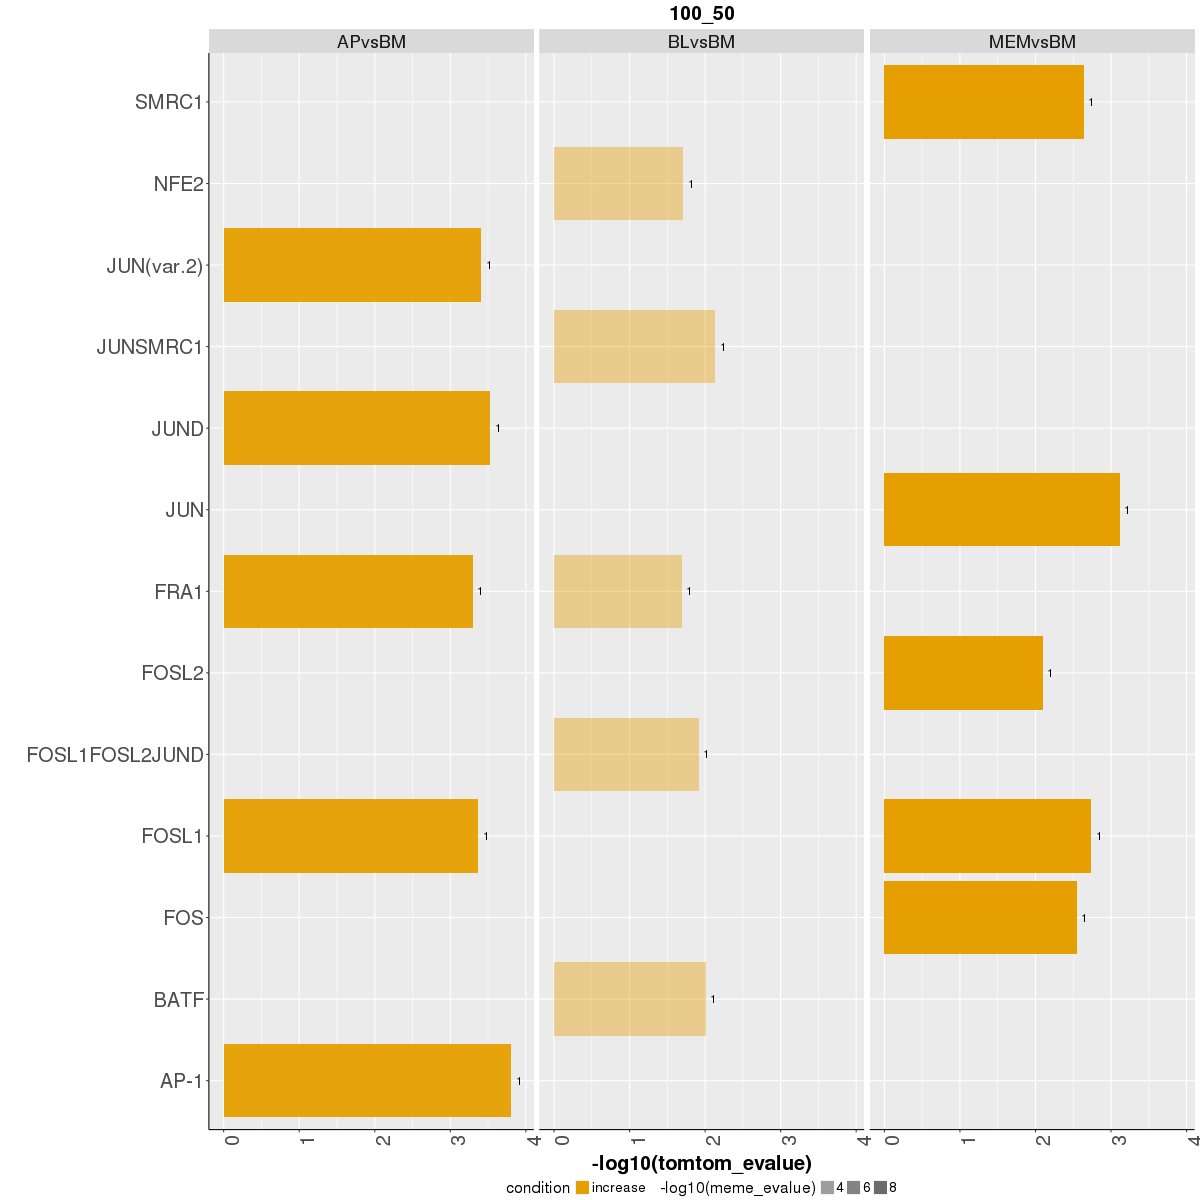

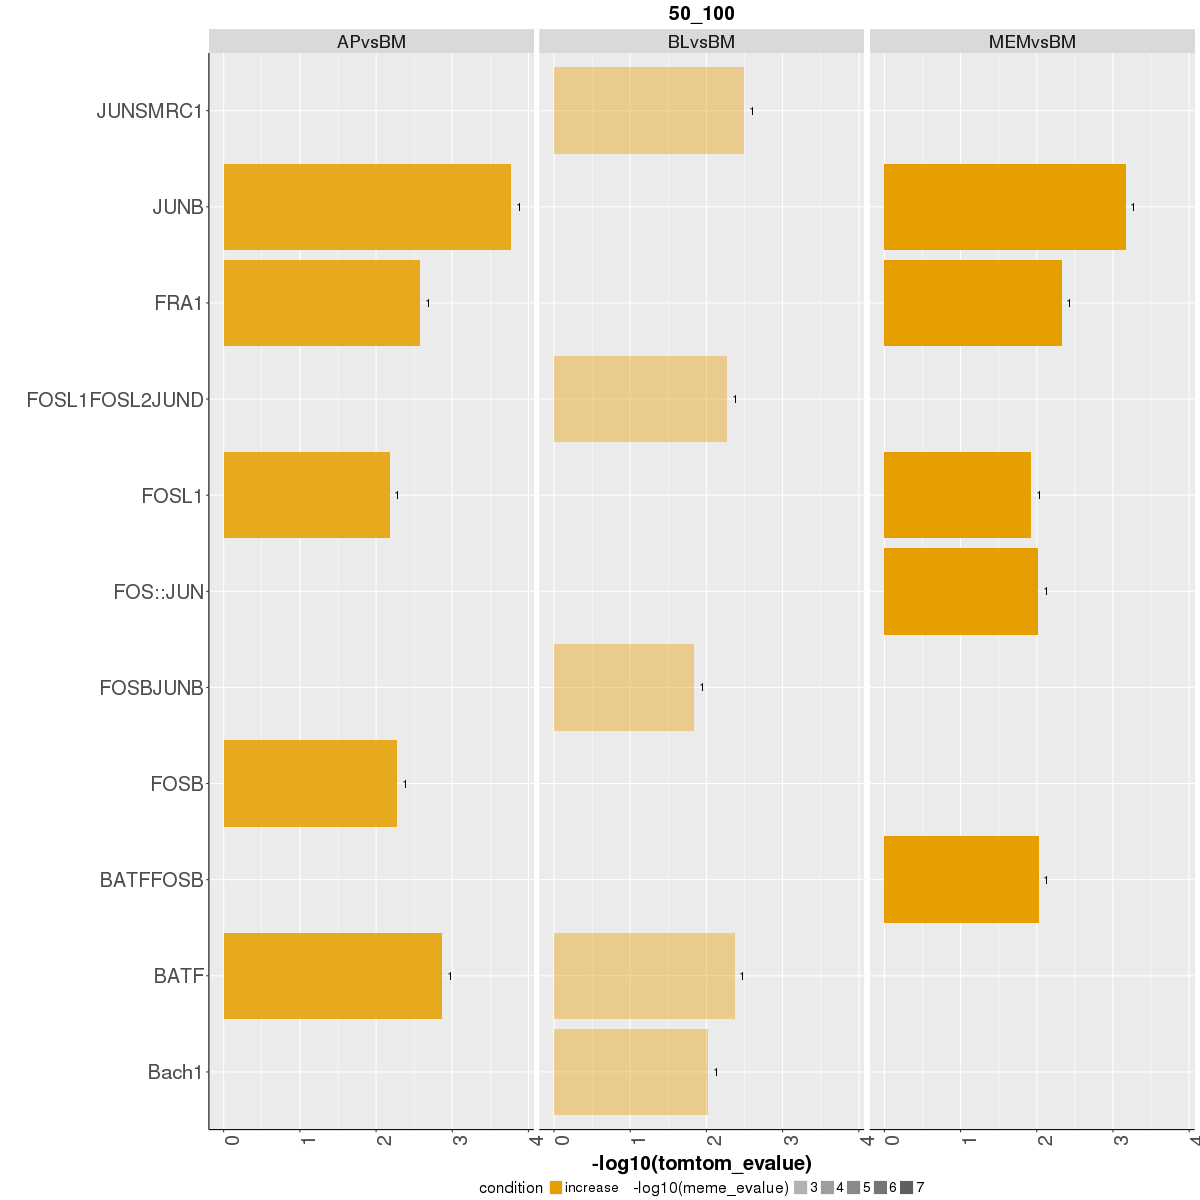

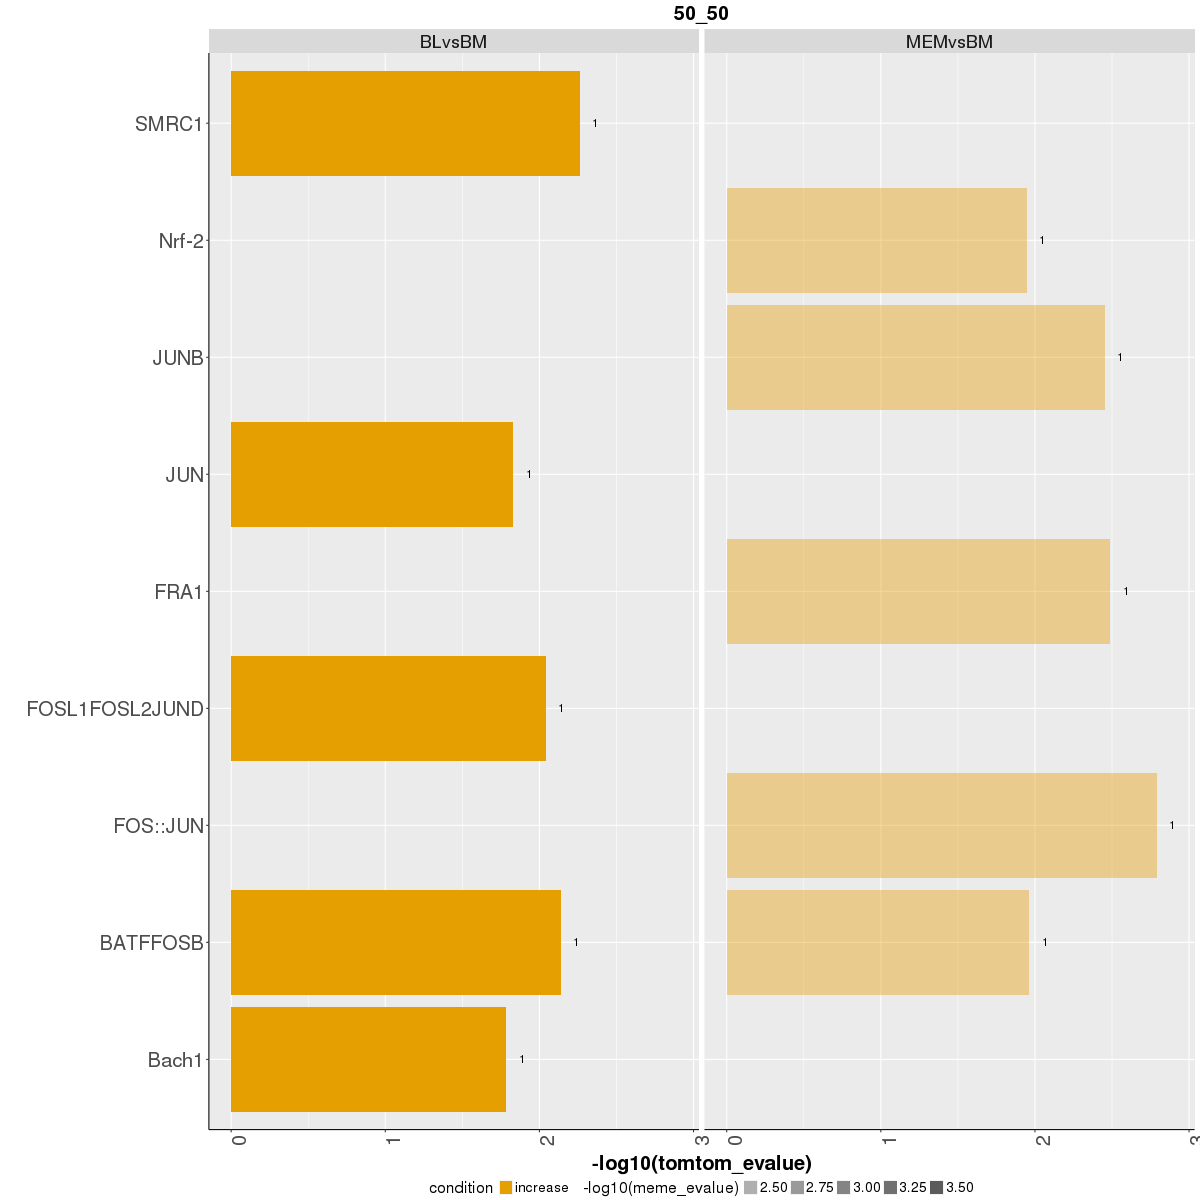

In [22]:
%%R -i tfs -w 1200 -h 1200

settings <- unique(tfs$settings)

for (setting in settings){
    p <- ggplot(subset(tfs, settings == setting), 
                aes(y=-log10(tomtom_evalue), x=motif_name, fill=condition, alpha=-log10(meme_evalue))) + 
            geom_bar(stat="identity", position="dodge") + 
            geom_text(aes(label=query_id, y=-log10(tomtom_evalue)+0.1), alpha=1) +
            coord_flip() +
            scale_alpha(range=c(0.4, 1)) + 
            facet_wrap( ~ DESeq2_comparison, nrow=1) +
            theme(axis.text.x=element_text(angle=90, hjust=1)) +
            scale_fill_manual(values=Palette) +
            theme(legend.position="bottom", legend.direction="horizontal") +
            labs(title=setting, x="")

    grid.arrange(p, ncol=1, nrow=1)
}


<br>
***
<br>
### Pick best run for motif analysis
- plots below are for one randomly chosen run setting
- re-run with choice of setting which is best suited for the data

In [75]:
import random
setting = random.choice(tfs["settings"].unique())
print "Random Setting: " + setting

Random Setting: 1000_100


In [76]:
tfs = meme_chip.groupby(["merge", "query_id", "DESeq2_comparison", "condition", "query_consensus", 
                         "meme_evalue", "tomtom_evalue", "settings"])["motif_name"].unique()
tfs = pd.DataFrame(tfs)
tfs.reset_index(inplace=True)
tfs["motif_name"] = tfs["motif_name"].apply(lambda x:''.join(x))
tfs["query_id"] = tfs["query_id"].astype(str)
tfs = tfs.groupby("merge").head(3)

In [77]:
tfs = tfs[tfs["settings"] == setting] # replace setting 

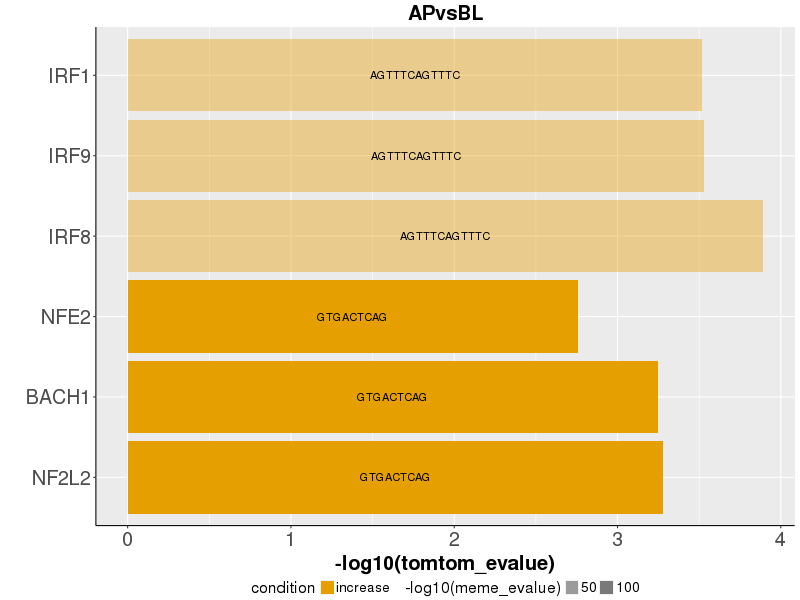

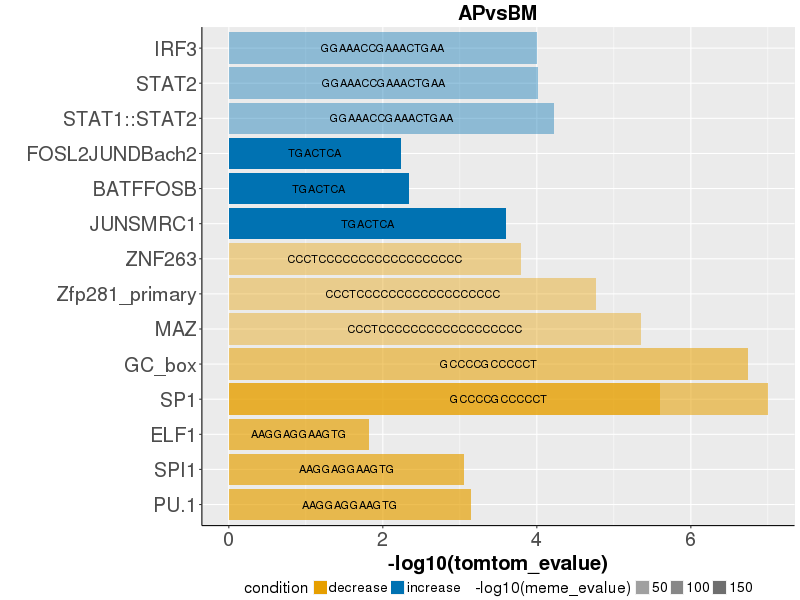

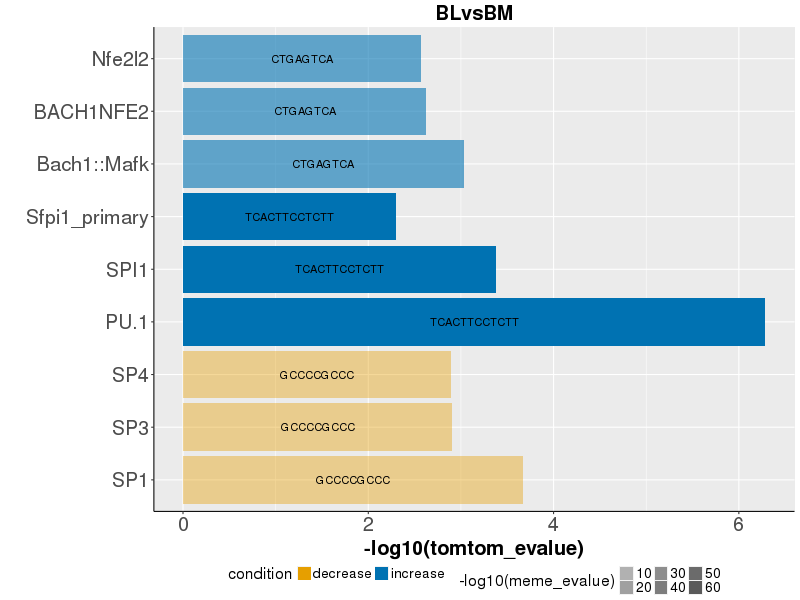

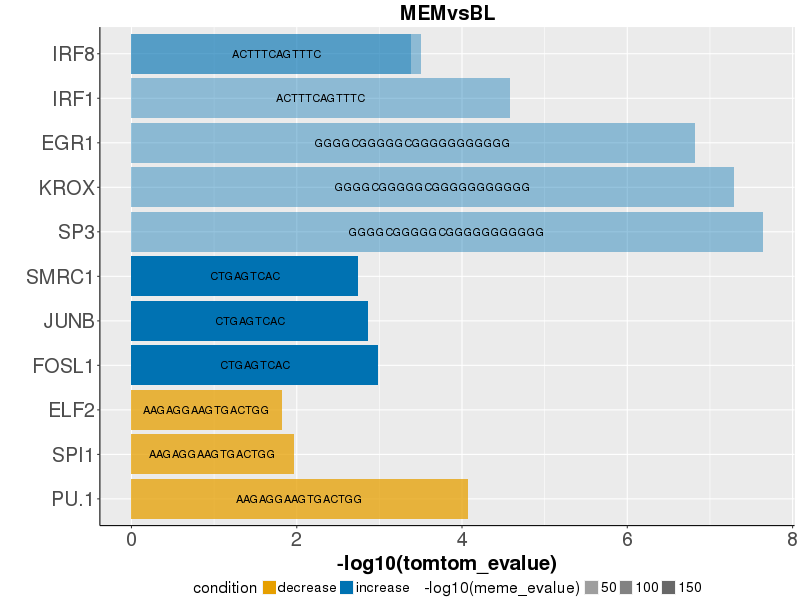

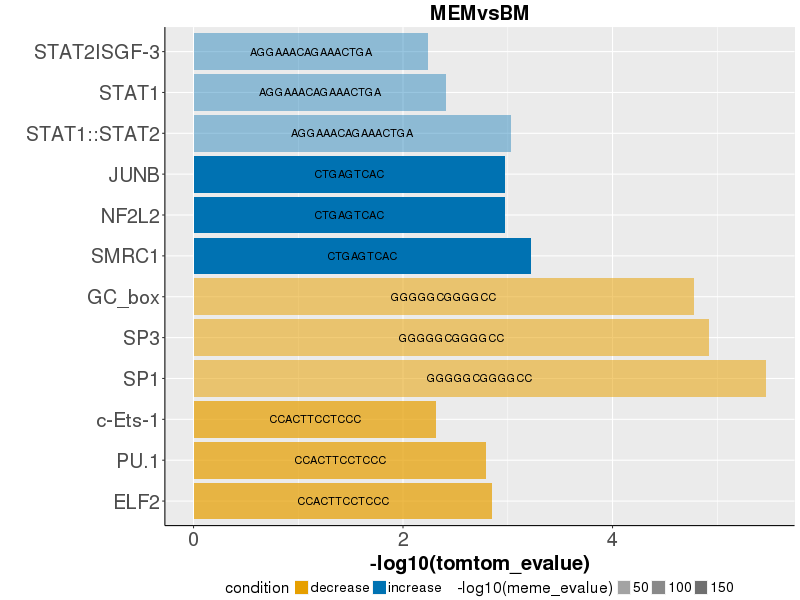

In [79]:
%%R -i tfs -w 800 -h 600

comparisons <- unique(tfs$DESeq2_comparison)

for (comp in comparisons){
    
    df <- subset(tfs, DESeq2_comparison == comp)
    df <- df[order(df$condition), ]
    
    p <- ggplot(df, 
                aes(y=-log10(tomtom_evalue), x=motif_name, fill=condition, alpha=-log10(meme_evalue))) + 
            geom_bar(stat="identity", position="dodge") + 
            geom_text(aes(label=query_consensus, y=-log10(tomtom_evalue)/2), alpha=1, 
                      check_overlap=TRUE, position=position_dodge(width=1)) +
            coord_flip() +
            scale_alpha(range=c(0.4, 1)) + 
            scale_fill_manual(values=Palette) +
            theme(legend.position="bottom", legend.direction="horizontal") +
            labs(title=df$DESeq2_comparison, x="") +
            scale_x_discrete(limits=unique(df$motif_name))

    grid.arrange(p, ncol=1, nrow=1)
}


<br>
## Top Motif Tables:
* Sorted by peak size & TOMTOM e-value

### Peaks with increased accessibility:

In [19]:
for i in meme_chip["DESeq2_comparison"].unique():
    print i
    meme_chip[(meme_chip.DESeq2_comparison == i) & (meme_chip.condition == "increase")].sort_values(["window", "tomtom_evalue"], ascending=True).drop_duplicates(["target_id", "motif_name", "orientation"], keep="first").head(10)

APvsBL


meme_evalue                       merge query_id      query_consensus  \
5408  9.200000e-42   APvsBL_increase_all_100_3        3  AAAAGAAACTGAAACTTAA   
586   2.200000e-05   APvsBL_increase_100_100_1        1            CTGAGTCAT   
587   2.200000e-05   APvsBL_increase_100_100_1        1            CTGAGTCAT   
589   2.200000e-05   APvsBL_increase_100_100_1        1            CTGAGTCAT   
2968  4.500000e-16   APvsBL_increase_500_100_2        2     GGGAAAGCGAAACTGA   
2824  1.100000e-60   APvsBL_increase_500_100_1        1            CTGAGTCAC   
2969  4.500000e-16   APvsBL_increase_500_100_2        2     GGGAAAGCGAAACTGA   
4190  4.500000e-14  APvsBL_increase_1000_100_2        2         AGTTTCAGTTTC   
2972  4.500000e-16   APvsBL_increase_500_100_2        2     GGGAAAGCGAAACTGA   
5409  9.200000e-42   APvsBL_increase_all_100_3        3  AAAAGAAACTGAAACTTAA   

                target_id   motif_name  database  tomtom_evalue orientation  \
5408   IRF1_MOUSE.H10MO.C         IRF1  hocomoco       0.000036           +   
586    NFE2_MOUSE.H10MO.A         NFE2  hocomoco       0.000040           -   
587              MA0501.1    MAF::NFE2    jaspar       0.000047           -   
589              MA0591.1  Bach1::Mafk    jaspar       0.000047           -   
2968  STAT2_MOUSE.H10MO.B        STAT2  hocomoco       0.000057           -   
2824  BACH1_MOUSE.H10MO.C        BACH1  hocomoco       0.000089           +   
2969               M00258       ISGF-3  transfac       0.000101           -   
4190             MA0652.1         IRF8    jaspar       0.000129           -   
2972   IRF3_MOUSE.H10MO.C         IRF3  hocomoco       0.000148           +   
5409             MA0050.2         IRF1    jaspar       0.000192           -   

                           run DESeq2_comparison condition no_peaks window  \
5408   APvsBL_increase_all_100            APvsBL  increase      all    100   
586    APvsBL_increase_100_100            APvsBL  increase      100    100   
587    APvsBL_increase_100_100            APvsBL  increase      100    100   
589    APvsBL_increase_100_100            APvsBL  increase      100    100   
2968   APvsBL_increase_500_100            APvsBL  increase      500    100   
2824   APvsBL_increase_500_100            APvsBL  increase      500    100   
2969   APvsBL_increase_500_100            APvsBL  increase      500    100   
4190  APvsBL_increase_1000_100            APvsBL  increase     1000    100   
2972   APvsBL_increase_500_100            APvsBL  increase      500    100   
5409   APvsBL_increase_all_100            APvsBL  increase      all    100   

      settings  
5408   all_100  
586    100_100  
587    100_100  
589    100_100  
2968   500_100  
2824   500_100  
2969   500_100  
4190  1000_100  
2972   500_100  
5409   all_100

MEMvsBL


meme_evalue                        merge query_id  \
53342  8.000000e-12  MEMvsBL_increase_1000_100_2        2   
53343  8.000000e-12  MEMvsBL_increase_1000_100_2        2   
53346  8.000000e-12  MEMvsBL_increase_1000_100_2        2   
54808  5.100000e-33   MEMvsBL_increase_all_100_3        3   
53348  8.000000e-12  MEMvsBL_increase_1000_100_2        2   
52150  8.400000e-05   MEMvsBL_increase_500_100_2        2   
53349  8.000000e-12  MEMvsBL_increase_1000_100_2        2   
54809  5.100000e-33   MEMvsBL_increase_all_100_3        3   
50288  2.300000e-02   MEMvsBL_increase_100_100_2        2   
52151  8.400000e-05   MEMvsBL_increase_500_100_2        2   

              query_consensus           target_id motif_name  database  \
53342  GGGGCGGGGGCGGGGGGGGGGG   SP3_MOUSE.H10MO.B        SP3  hocomoco   
53343  GGGGCGGGGGCGGGGGGGGGGG              M00982       KROX  transfac   
53346  GGGGCGGGGGCGGGGGGGGGGG            MA0162.2       EGR1    jaspar   
54808  CCCCCCCCCGCCCCCACCCCCG   SP4_MOUSE.H10MO.D        SP4  hocomoco   
53348  GGGGCGGGGGCGGGGGGGGGGG   SP4_MOUSE.H10MO.D        SP4  hocomoco   
52150            GAAAGCGAAACT  IRF1_MOUSE.H10MO.C       IRF1  hocomoco   
53349  GGGGCGGGGGCGGGGGGGGGGG   WT1_MOUSE.H10MO.D        WT1  hocomoco   
54809  CCCCCCCCCGCCCCCACCCCCG   SP3_MOUSE.H10MO.B        SP3  hocomoco   
50288        AGTTTCACTTTCACTT            MA0050.2       IRF1    jaspar   
52151            GAAAGCGAAACT  IRF9_MOUSE.H10MO.C       IRF9  hocomoco   

       tomtom_evalue orientation                        run DESeq2_comparison  \
53342   2.283530e-08           +  MEMvsBL_increase_1000_100           MEMvsBL   
53343   5.150230e-08           -  MEMvsBL_increase_1000_100           MEMvsBL   
53346   1.528210e-07           -  MEMvsBL_increase_1000_100           MEMvsBL   
54808   2.395530e-07           -   MEMvsBL_increase_all_100           MEMvsBL   
53348   3.201700e-07           +  MEMvsBL_increase_1000_100           MEMvsBL   
52150   2.661270e-06           +   MEMvsBL_increase_500_100           MEMvsBL   
53349   2.928110e-06           +  MEMvsBL_increase_1000_100           MEMvsBL   
54809   5.425030e-06           -   MEMvsBL_increase_all_100           MEMvsBL   
50288   8.505490e-06           +   MEMvsBL_increase_100_100           MEMvsBL   
52151   1.467770e-05           +   MEMvsBL_increase_500_100           MEMvsBL   

      condition no_peaks window  settings  
53342  increase     1000    100  1000_100  
53343  increase     1000    100  1000_100  
53346  increase     1000    100  1000_100  
54808  increase      all    100   all_100  
53348  increase     1000    100  1000_100  
52150  increase      500    100   500_100  
53349  increase     1000    100  1000_100  
54809  increase      all    100   all_100  
50288  increase      100    100   100_100  
52151  increase      500    100   500_100

APvsBM


meme_evalue                       merge query_id  \
16128  5.900000e-40   APvsBM_increase_all_100_2        2   
16129  5.900000e-40   APvsBM_increase_all_100_2        2   
16130  5.900000e-40   APvsBM_increase_all_100_2        2   
16131  5.900000e-40   APvsBM_increase_all_100_2        2   
14968  3.000000e-09  APvsBM_increase_1000_100_2        2   
12472  9.000000e-31   APvsBM_increase_200_100_1        1   
14970  3.000000e-09  APvsBM_increase_1000_100_2        2   
14971  3.000000e-09  APvsBM_increase_1000_100_2        2   
11324  4.700000e-15   APvsBM_increase_100_100_1        1   
10788  3.700000e-07    APvsBM_increase_50_100_1        1   

              query_consensus            target_id      motif_name  database  \
16128  CCCCCCCCCCCCCCCCCACCCC    SP4_MOUSE.H10MO.D             SP4  hocomoco   
16129  CCCCCCCCCCCCCCCCCACCCC    SP3_MOUSE.H10MO.B             SP3  hocomoco   
16130  CCCCCCCCCCCCCCCCCACCCC    MAZ_MOUSE.H10MO.D             MAZ  hocomoco   
16131  CCCCCCCCCCCCCCCCCACCCC            UP00021_1  Zfp281_primary  uniprobe   
14968        GGAAACCGAAACTGAA             MA0517.1    STAT1::STAT2    jaspar   
12472               CTGAGTCAC  BACH1_MOUSE.H10MO.C           BACH1  hocomoco   
14970        GGAAACCGAAACTGAA  STAT2_MOUSE.H10MO.B           STAT2  hocomoco   
14971        GGAAACCGAAACTGAA   IRF3_MOUSE.H10MO.C            IRF3  hocomoco   
11324                 TGACTCA   JUNB_MOUSE.H10MO.B            JUNB  hocomoco   
10788                 TGAGTCA   JUNB_MOUSE.H10MO.B            JUNB  hocomoco   

       tomtom_evalue orientation                       run DESeq2_comparison  \
16128   1.362360e-07           -   APvsBM_increase_all_100            APvsBM   
16129   2.040040e-06           -   APvsBM_increase_all_100            APvsBM   
16130   9.881360e-06           -   APvsBM_increase_all_100            APvsBM   
16131   5.518740e-05           +   APvsBM_increase_all_100            APvsBM   
14968   5.976370e-05           -  APvsBM_increase_1000_100            APvsBM   
12472   6.211390e-05           +   APvsBM_increase_200_100            APvsBM   
14970   9.648660e-05           -  APvsBM_increase_1000_100            APvsBM   
14971   1.007280e-04           +  APvsBM_increase_1000_100            APvsBM   
11324   1.446870e-04           -   APvsBM_increase_100_100            APvsBM   
10788   1.673470e-04           +    APvsBM_increase_50_100            APvsBM   

      condition no_peaks window  settings  
16128  increase      all    100   all_100  
16129  increase      all    100   all_100  
16130  increase      all    100   all_100  
16131  increase      all    100   all_100  
14968  increase     1000    100  1000_100  
12472  increase      200    100   200_100  
14970  increase     1000    100  1000_100  
14971  increase     1000    100  1000_100  
11324  increase      100    100   100_100  
10788  increase       50    100    50_100

MEMvsBM


meme_evalue                       merge query_id  \
42172  2.600000e-52  MEMvsBM_increase_all_100_2        2   
42173  2.600000e-52  MEMvsBM_increase_all_100_2        2   
39726  9.300000e-05  MEMvsBM_increase_500_100_2        2   
38548  7.400000e-35  MEMvsBM_increase_200_100_1        1   
38549  7.400000e-35  MEMvsBM_increase_200_100_1        1   
38550  7.400000e-35  MEMvsBM_increase_200_100_1        1   
42174  2.600000e-52  MEMvsBM_increase_all_100_2        2   
42177  2.600000e-52  MEMvsBM_increase_all_100_2        2   
42178  2.600000e-52  MEMvsBM_increase_all_100_2        2   
39728  9.300000e-05  MEMvsBM_increase_500_100_2        2   

              query_consensus            target_id motif_name  database  \
42172  CGGGGGGGGGGGGCGGGGGGGG    SP4_MOUSE.H10MO.D        SP4  hocomoco   
42173  CGGGGGGGGGGGGCGGGGGGGG    SP3_MOUSE.H10MO.B        SP3  hocomoco   
39726        TTTTACTTTCAGTTTC             MA0050.2       IRF1    jaspar   
38548               GTGACTCAT  FOSL1_MOUSE.H10MO.C      FOSL1  hocomoco   
38549               GTGACTCAT    JUN_MOUSE.H10MO.A        JUN  hocomoco   
38550               GTGACTCAT  SMRC1_MOUSE.H10MO.B      SMRC1  hocomoco   
42174  CGGGGGGGGGGGGCGGGGGGGG               M00982       KROX  transfac   
42177  CGGGGGGGGGGGGCGGGGGGGG    MAZ_MOUSE.H10MO.D        MAZ  hocomoco   
42178  CGGGGGGGGGGGGCGGGGGGGG  ZN148_MOUSE.H10MO.D      ZN148  hocomoco   
39728        TTTTACTTTCAGTTTC   IRF1_MOUSE.H10MO.C       IRF1  hocomoco   

       tomtom_evalue orientation                       run DESeq2_comparison  \
42172       0.000002           +  MEMvsBM_increase_all_100           MEMvsBM   
42173       0.000003           +  MEMvsBM_increase_all_100           MEMvsBM   
39726       0.000003           +  MEMvsBM_increase_500_100           MEMvsBM   
38548       0.000008           +  MEMvsBM_increase_200_100           MEMvsBM   
38549       0.000015           -  MEMvsBM_increase_200_100           MEMvsBM   
38550       0.000015           -  MEMvsBM_increase_200_100           MEMvsBM   
42174       0.000038           -  MEMvsBM_increase_all_100           MEMvsBM   
42177       0.000087           +  MEMvsBM_increase_all_100           MEMvsBM   
42178       0.000128           +  MEMvsBM_increase_all_100           MEMvsBM   
39728       0.000134           -  MEMvsBM_increase_500_100           MEMvsBM   

      condition no_peaks window settings  
42172  increase      all    100  all_100  
42173  increase      all    100  all_100  
39726  increase      500    100  500_100  
38548  increase      200    100  200_100  
38549  increase      200    100  200_100  
38550  increase      200    100  200_100  
42174  increase      all    100  all_100  
42177  increase      all    100  all_100  
42178  increase      all    100  all_100  
39728  increase      500    100  500_100

BLvsBM


meme_evalue                       merge query_id query_consensus  \
28170  2.600000e-61  BLvsBM_increase_1000_100_1        1    TCACTTCCTCTT   
25116  1.100000e-07   BLvsBM_increase_100_100_2        2       AAGAGGAAG   
25119  1.100000e-07   BLvsBM_increase_100_100_2        2       AAGAGGAAG   
24972  2.800000e-06   BLvsBM_increase_100_100_1        1         TGAGTCA   
25180  5.000000e-03   BLvsBM_increase_100_100_3        3    CCCCCCCCCCCA   
27185  9.200000e-59   BLvsBM_increase_500_100_1        1    TCACTTCCTCTT   
26375  3.200000e-08   BLvsBM_increase_200_100_3        3    TCACTTCCTCTT   
25181  5.000000e-03   BLvsBM_increase_100_100_3        3    CCCCCCCCCCCA   
28322  9.900000e-26  BLvsBM_increase_1000_100_3        3        CTGAGTCA   
25120  1.100000e-07   BLvsBM_increase_100_100_2        2       AAGAGGAAG   

                target_id      motif_name  database  tomtom_evalue  \
28170              M01172            PU.1  transfac   5.169720e-07   
25116              M01172            PU.1  transfac   4.661290e-05   
25119  SPI1_MOUSE.H10MO.A            SPI1  hocomoco   8.573740e-05   
24972  BATF_MOUSE.H10MO.B            BATF  hocomoco   9.484940e-05   
25180           UP00022_1  Zfp740_primary  uniprobe   2.716310e-04   
27185  SPI1_MOUSE.H10MO.A            SPI1  hocomoco   3.193240e-04   
26375           UP00085_1   Sfpi1_primary  uniprobe   6.836670e-04   
25181           UP00021_1  Zfp281_primary  uniprobe   8.478870e-04   
28322            MA0591.1     Bach1::Mafk    jaspar   9.318770e-04   
25120           UP00085_1   Sfpi1_primary  uniprobe   1.440850e-03   

      orientation                       run DESeq2_comparison condition  \
28170           +  BLvsBM_increase_1000_100            BLvsBM  increase   
25116           -   BLvsBM_increase_100_100            BLvsBM  increase   
25119           +   BLvsBM_increase_100_100            BLvsBM  increase   
24972           +   BLvsBM_increase_100_100            BLvsBM  increase   
25180           +   BLvsBM_increase_100_100            BLvsBM  increase   
27185           -   BLvsBM_increase_500_100            BLvsBM  increase   
26375           -   BLvsBM_increase_200_100            BLvsBM  increase   
25181           +   BLvsBM_increase_100_100            BLvsBM  increase   
28322           -  BLvsBM_increase_1000_100            BLvsBM  increase   
25120           +   BLvsBM_increase_100_100            BLvsBM  increase   

      no_peaks window  settings  
28170     1000    100  1000_100  
25116      100    100   100_100  
25119      100    100   100_100  
24972      100    100   100_100  
25180      100    100   100_100  
27185      500    100   500_100  
26375      200    100   200_100  
25181      100    100   100_100  
28322     1000    100  1000_100  
25120      100    100   100_100

### Peaks with decreased accessibility:

In [20]:
for i in meme_chip["DESeq2_comparison"].unique():
    print i
    meme_chip[(meme_chip.DESeq2_comparison == i) & (meme_chip.condition == "decrease")].sort_values(["window", "tomtom_evalue"], ascending=True).drop_duplicates(["target_id", "motif_name", "orientation"], keep="first").head(10)

APvsBL


meme_evalue                      merge query_id   query_consensus  \
9726  1.100000e-147  APvsBL_decrease_all_100_1        1   AGAAAGAGGAAGTGA   
6780   1.400000e-21  APvsBL_decrease_200_100_1        1  GGGGAGGAAGTGGGGG   
9730  1.100000e-147  APvsBL_decrease_all_100_1        1   AGAAAGAGGAAGTGA   
7682   1.100000e-58  APvsBL_decrease_500_100_1        1      CACTTCCTCCTT   
7683   1.100000e-58  APvsBL_decrease_500_100_1        1      CACTTCCTCCTT   
9731  1.100000e-147  APvsBL_decrease_all_100_1        1   AGAAAGAGGAAGTGA   
9732  1.100000e-147  APvsBL_decrease_all_100_1        1   AGAAAGAGGAAGTGA   
6783   1.400000e-21  APvsBL_decrease_200_100_1        1  GGGGAGGAAGTGGGGG   
9734  1.100000e-147  APvsBL_decrease_all_100_1        1   AGAAAGAGGAAGTGA   
9737  1.100000e-147  APvsBL_decrease_all_100_1        1   AGAAAGAGGAAGTGA   

                target_id  motif_name  database  tomtom_evalue orientation  \
9726   SPI1_MOUSE.H10MO.A        SPI1  hocomoco       0.000011           +   
6780               M01172        PU.1  transfac       0.000021           -   
9730  STAT1_MOUSE.H10MO.A       STAT1  hocomoco       0.000099           -   
7682   SPI1_MOUSE.H10MO.A        SPI1  hocomoco       0.000765           -   
7683               M01172        PU.1  transfac       0.001224           +   
9731   SPIB_MOUSE.H10MO.B        SPIB  hocomoco       0.002805           +   
9732             MA0687.1        SPIC    jaspar       0.003409           +   
6783             MA0528.1      ZNF263    jaspar       0.003568           +   
9734               M01203  SPI1_(PU1)  transfac       0.003646           +   
9737             MA0508.1       PRDM1    jaspar       0.004943           +   

                          run DESeq2_comparison condition no_peaks window  \
9726  APvsBL_decrease_all_100            APvsBL  decrease      all    100   
6780  APvsBL_decrease_200_100            APvsBL  decrease      200    100   
9730  APvsBL_decrease_all_100            APvsBL  decrease      all    100   
7682  APvsBL_decrease_500_100            APvsBL  decrease      500    100   
7683  APvsBL_decrease_500_100            APvsBL  decrease      500    100   
9731  APvsBL_decrease_all_100            APvsBL  decrease      all    100   
9732  APvsBL_decrease_all_100            APvsBL  decrease      all    100   
6783  APvsBL_decrease_200_100            APvsBL  decrease      200    100   
9734  APvsBL_decrease_all_100            APvsBL  decrease      all    100   
9737  APvsBL_decrease_all_100            APvsBL  decrease      all    100   

     settings  
9726  all_100  
6780  200_100  
9730  all_100  
7682  500_100  
7683  500_100  
9731  all_100  
9732  all_100  
6783  200_100  
9734  all_100  
9737  all_100

MEMvsBL


meme_evalue                        merge query_id   query_consensus  \
56552   1.800000e-70   MEMvsBL_decrease_500_100_1        1      AAGAGGAAGTGA   
56555   1.800000e-70   MEMvsBL_decrease_500_100_1        1      AAGAGGAAGTGA   
57657  2.700000e-106  MEMvsBL_decrease_1000_100_1        1  AAGAGGAAGTGACTGG   
57658  2.700000e-106  MEMvsBL_decrease_1000_100_1        1  AAGAGGAAGTGACTGG   
56557   1.800000e-70   MEMvsBL_decrease_500_100_1        1      AAGAGGAAGTGA   
56558   1.800000e-70   MEMvsBL_decrease_500_100_1        1      AAGAGGAAGTGA   
56559   1.800000e-70   MEMvsBL_decrease_500_100_1        1      AAGAGGAAGTGA   
57659  2.700000e-106  MEMvsBL_decrease_1000_100_1        1  AAGAGGAAGTGACTGG   
56565   1.800000e-70   MEMvsBL_decrease_500_100_1        1      AAGAGGAAGTGA   
56568   1.800000e-70   MEMvsBL_decrease_500_100_1        1      AAGAGGAAGTGA   

                 target_id     motif_name  database  tomtom_evalue  \
56552               M01172           PU.1  transfac       0.000009   
56555   SPI1_MOUSE.H10MO.A           SPI1  hocomoco       0.000911   
57657               M02078           SPI1  transfac       0.010919   
57658   ELF2_MOUSE.H10MO.C           ELF2  hocomoco       0.015076   
56557  STAT1_MOUSE.H10MO.A          STAT1  hocomoco       0.026115   
56558            UP00085_1  Sfpi1_primary  uniprobe       0.027260   
56559               M00971            Ets  transfac       0.027271   
57659               M02076          Spi-B  transfac       0.028921   
56565               M02077           Spic  transfac       0.030441   
56568   IRF4_MOUSE.H10MO.C           IRF4  hocomoco       0.031524   

      orientation                        run DESeq2_comparison condition  \
56552           -   MEMvsBL_decrease_500_100           MEMvsBL  decrease   
56555           +   MEMvsBL_decrease_500_100           MEMvsBL  decrease   
57657           +  MEMvsBL_decrease_1000_100           MEMvsBL  decrease   
57658           +  MEMvsBL_decrease_1000_100           MEMvsBL  decrease   
56557           -   MEMvsBL_decrease_500_100           MEMvsBL  decrease   
56558           +   MEMvsBL_decrease_500_100           MEMvsBL  decrease   
56559           -   MEMvsBL_decrease_500_100           MEMvsBL  decrease   
57659           +  MEMvsBL_decrease_1000_100           MEMvsBL  decrease   
56565           +   MEMvsBL_decrease_500_100           MEMvsBL  decrease   
56568           +   MEMvsBL_decrease_500_100           MEMvsBL  decrease   

      no_peaks window  settings  
56552      500    100   500_100  
56555      500    100   500_100  
57657     1000    100  1000_100  
57658     1000    100  1000_100  
56557      500    100   500_100  
56558      500    100   500_100  
56559      500    100   500_100  
57659     1000    100  1000_100  
56565      500    100   500_100  
56568      500    100   500_100

APvsBM


meme_evalue                       merge query_id  \
22988  6.100000e-96   APvsBM_decrease_all_100_2        2   
21030  3.100000e-56  APvsBM_decrease_1000_100_2        2   
21031  3.100000e-56  APvsBM_decrease_1000_100_2        2   
22989  6.100000e-96   APvsBM_decrease_all_100_2        2   
19344  2.100000e-26   APvsBM_decrease_500_100_2        2   
22992  6.100000e-96   APvsBM_decrease_all_100_2        2   
21034  3.100000e-56  APvsBM_decrease_1000_100_2        2   
21202  3.700000e-10  APvsBM_decrease_1000_100_3        3   
19347  2.100000e-26   APvsBM_decrease_500_100_2        2   
21203  3.700000e-10  APvsBM_decrease_1000_100_3        3   

              query_consensus            target_id      motif_name  database  \
22988        GGCCCCGCCCCCCCCC    SP3_MOUSE.H10MO.B             SP3  hocomoco   
21030            GCCCCGCCCCCT    SP1_MOUSE.H10MO.S             SP1  hocomoco   
21031            GCCCCGCCCCCT               M00255          GC_box  transfac   
22989        GGCCCCGCCCCCCCCC             MA0516.1             SP2    jaspar   
19344        CCCCGCCCCCCCCCCC               M00933             Sp1  transfac   
22992        GGCCCCGCCCCCCCCC    SP4_MOUSE.H10MO.D             SP4  hocomoco   
21034            GCCCCGCCCCCT             MA0079.3             SP1    jaspar   
21202  CCCTCCCCCCCCCCCCCCCCCC    MAZ_MOUSE.H10MO.D             MAZ  hocomoco   
19347        CCCCGCCCCCCCCCCC  ZN148_MOUSE.H10MO.D           ZN148  hocomoco   
21203  CCCTCCCCCCCCCCCCCCCCCC            UP00021_1  Zfp281_primary  uniprobe   

       tomtom_evalue orientation                       run DESeq2_comparison  \
22988   1.020100e-08           -   APvsBM_decrease_all_100            APvsBM   
21030   1.008260e-07           -  APvsBM_decrease_1000_100            APvsBM   
21031   1.802940e-07           -  APvsBM_decrease_1000_100            APvsBM   
22989   2.448730e-07           +   APvsBM_decrease_all_100            APvsBM   
19344   1.612170e-06           +   APvsBM_decrease_500_100            APvsBM   
22992   2.202070e-06           -   APvsBM_decrease_all_100            APvsBM   
21034   2.506480e-06           +  APvsBM_decrease_1000_100            APvsBM   
21202   4.489110e-06           -  APvsBM_decrease_1000_100            APvsBM   
19347   4.635980e-06           -   APvsBM_decrease_500_100            APvsBM   
21203   1.711500e-05           +  APvsBM_decrease_1000_100            APvsBM   

      condition no_peaks window  settings  
22988  decrease      all    100   all_100  
21030  decrease     1000    100  1000_100  
21031  decrease     1000    100  1000_100  
22989  decrease      all    100   all_100  
19344  decrease      500    100   500_100  
22992  decrease      all    100   all_100  
21034  decrease     1000    100  1000_100  
21202  decrease     1000    100  1000_100  
19347  decrease      500    100   500_100  
21203  decrease     1000    100  1000_100

MEMvsBM


meme_evalue                        merge query_id   query_consensus  \
45076   4.100000e-35   MEMvsBM_decrease_500_100_2        2  GGCCCCGCCCCCCGCC   
45078   4.100000e-35   MEMvsBM_decrease_500_100_2        2  GGCCCCGCCCCCCGCC   
48564  5.300000e-228   MEMvsBM_decrease_all_100_1        1  CCCCCACTTCCTCTTT   
48819   2.000000e-92   MEMvsBM_decrease_all_100_2        2      GGCCCCGCCCCC   
46874   3.700000e-55  MEMvsBM_decrease_1000_100_2        2      GGGGGCGGGGCC   
46875   3.700000e-55  MEMvsBM_decrease_1000_100_2        2      GGGGGCGGGGCC   
48820   2.000000e-92   MEMvsBM_decrease_all_100_2        2      GGCCCCGCCCCC   
46876   3.700000e-55  MEMvsBM_decrease_1000_100_2        2      GGGGGCGGGGCC   
46879   3.700000e-55  MEMvsBM_decrease_1000_100_2        2      GGGGGCGGGGCC   
48822   2.000000e-92   MEMvsBM_decrease_all_100_2        2      GGCCCCGCCCCC   

               target_id motif_name  database  tomtom_evalue orientation  \
45076           MA0516.1        SP2    jaspar   2.128710e-07           +   
45078  SP3_MOUSE.H10MO.B        SP3  hocomoco   2.158790e-07           -   
48564             M01172       PU.1  transfac   3.393150e-07           +   
48819  SP1_MOUSE.H10MO.S        SP1  hocomoco   2.105900e-06           -   
46874  SP1_MOUSE.H10MO.S        SP1  hocomoco   3.434990e-06           +   
46875  SP3_MOUSE.H10MO.B        SP3  hocomoco   1.192190e-05           +   
48820           MA0079.3        SP1    jaspar   1.334600e-05           +   
46876             M00255     GC_box  transfac   1.655580e-05           +   
46879           MA0079.3        SP1    jaspar   2.015140e-05           -   
48822             M00255     GC_box  transfac   2.767560e-05           -   

                             run DESeq2_comparison condition no_peaks window  \
45076   MEMvsBM_decrease_500_100           MEMvsBM  decrease      500    100   
45078   MEMvsBM_decrease_500_100           MEMvsBM  decrease      500    100   
48564   MEMvsBM_decrease_all_100           MEMvsBM  decrease      all    100   
48819   MEMvsBM_decrease_all_100           MEMvsBM  decrease      all    100   
46874  MEMvsBM_decrease_1000_100           MEMvsBM  decrease     1000    100   
46875  MEMvsBM_decrease_1000_100           MEMvsBM  decrease     1000    100   
48820   MEMvsBM_decrease_all_100           MEMvsBM  decrease      all    100   
46876  MEMvsBM_decrease_1000_100           MEMvsBM  decrease     1000    100   
46879  MEMvsBM_decrease_1000_100           MEMvsBM  decrease     1000    100   
48822   MEMvsBM_decrease_all_100           MEMvsBM  decrease      all    100   

       settings  
45076   500_100  
45078   500_100  
48564   all_100  
48819   all_100  
46874  1000_100  
46875  1000_100  
48820   all_100  
46876  1000_100  
46879  1000_100  
48822   all_100

BLvsBM


meme_evalue                      merge query_id   query_consensus  \
32740  1.100000e-08  BLvsBM_decrease_500_100_1        1         GCCCCGCCC   
32741  1.100000e-08  BLvsBM_decrease_500_100_1        1         GCCCCGCCC   
32742  1.100000e-08  BLvsBM_decrease_500_100_1        1         GCCCCGCCC   
32743  1.100000e-08  BLvsBM_decrease_500_100_1        1         GCCCCGCCC   
31591  3.300000e-03  BLvsBM_decrease_200_100_2        2         GCCCCGCCC   
32745  1.100000e-08  BLvsBM_decrease_500_100_1        1         GCCCCGCCC   
31596  3.300000e-03  BLvsBM_decrease_200_100_2        2         GCCCCGCCC   
31564  5.100000e-09  BLvsBM_decrease_200_100_1        1  TTTCCTTCCTTTCTGT   
32752  1.100000e-08  BLvsBM_decrease_500_100_1        1         GCCCCGCCC   
31600  3.300000e-03  BLvsBM_decrease_200_100_2        2         GCCCCGCCC   

               target_id   motif_name  database  tomtom_evalue orientation  \
32740  SP1_MOUSE.H10MO.S          SP1  hocomoco       0.000213           -   
32741  SP3_MOUSE.H10MO.B          SP3  hocomoco       0.001242           -   
32742             M01273          SP4  transfac       0.001280           +   
32743           MA0079.3          SP1    jaspar       0.002318           +   
31591           MA0599.1         KLF5    jaspar       0.002773           +   
32745             M00255       GC_box  transfac       0.003019           -   
31596           MA0039.2         Klf4    jaspar       0.003717           -   
31564           MA0149.1   EWSR1-FLI1    jaspar       0.005984           -   
32752           MA0516.1          SP2    jaspar       0.007746           +   
31600             M01588  GKLF_(KLF4)  transfac       0.008901           +   

                           run DESeq2_comparison condition no_peaks window  \
32740  BLvsBM_decrease_500_100            BLvsBM  decrease      500    100   
32741  BLvsBM_decrease_500_100            BLvsBM  decrease      500    100   
32742  BLvsBM_decrease_500_100            BLvsBM  decrease      500    100   
32743  BLvsBM_decrease_500_100            BLvsBM  decrease      500    100   
31591  BLvsBM_decrease_200_100            BLvsBM  decrease      200    100   
32745  BLvsBM_decrease_500_100            BLvsBM  decrease      500    100   
31596  BLvsBM_decrease_200_100            BLvsBM  decrease      200    100   
31564  BLvsBM_decrease_200_100            BLvsBM  decrease      200    100   
32752  BLvsBM_decrease_500_100            BLvsBM  decrease      500    100   
31600  BLvsBM_decrease_200_100            BLvsBM  decrease      200    100   

      settings  
32740  500_100  
32741  500_100  
32742  500_100  
32743  500_100  
31591  200_100  
32745  500_100  
31596  200_100  
31564  200_100  
32752  500_100  
31600  200_100